# Final Project Submission

Please fill out:
* Student name: Jessica Miles
* Student pace: Full Time
* Scheduled project review date/time: 4/26/2021 at 3 PM EST
* Instructor name: James Irving

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br>
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

## Business Problem

Acme Real Estate Association would like to use data to understand how they can serve their customers better and increase their business. They would like to create marketing and educational material to enable their team of agents to make informed recommendations to customers about how to increase home sale prices. Although they already have plenty of experience and domain expertise, they want to confirm their intuitions and back it up with real data.

The two main questions they have are:
1. Which home features contribute most to higher sale price? Acme wants information about all factors which contribute significantly to sale price, so they can confirm their team's intuitions and educate their customers.
2. What are the most effective strategies homeowners can employ to increase the eventual sale price of their home? This should focus on features homeowners can control. 

# OBTAIN

## Data Understanding

For this project, we will use data from home sales where Acme is based, in King County, WA. 

Our data spans about a year between May 2, 2014 and May 27, 2015. It includes about 21,000 homes sold in most zip codes in King County, with the exception of zip codes in the heart of downtown Seattle.

We will use Price as our target variable, and will investigate a variety of dependent or predictor variables representing home features that homeowners can feasibly control, such as square footage, grade and condition, and number of bedrooms and bathrooms. We will also investigate the impact of home features that homeowners can't control, such as zip code, environmental variables such as being  on the waterfront or having a scenic view, and the square footage of their lot. Our goal will be to compare the impact on Price of both variables that homeowners can and can't control, and craft actionable recommendations based on this insight.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import missingno as msno

from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder

In [2]:
# Format floats as currency and abbreviate them for visualizations
# Source: https://pbpython.com/effective-matplotlib.html

# {:1.1f} in this case means: apply format to the first 1 instance
# that value should be presented with .1f = as a float with 1 point precision
# change the second number to increase or decrease precision

def currency(x, pos=None):
    'The two args are the value and tick position'
    # over 1 billion
    if abs(x) >= 1000000000:
        return '${:1.2f} B'.format(x*1e-9)
    # over 10 million
    elif abs(x) >= 10000000:
        return '${:1.1f} M'.format(x*1e-6)
    # over 1 million
    elif abs(x) >= 1000000:
        return '${:1.2f} M'.format(x*1e-6)
    elif x == 0:
        return '${:0}'.format(x)
    else:
        return '${:1.0f} K'.format(x*1e-3)

## Initial Import

In [3]:
# import raw data
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Explore Dates

In [5]:
# Explore the date range of sales that we have

#Convert to datetime type
df['date'] = pd.to_datetime(df['date'])

# Explore date range that we have
df['date'].describe(datetime_is_numeric=True)

count                            21597
mean     2014-10-29 04:20:38.171968512
min                2014-05-02 00:00:00
25%                2014-07-22 00:00:00
50%                2014-10-16 00:00:00
75%                2015-02-17 00:00:00
max                2015-05-27 00:00:00
Name: date, dtype: object

Dates range from May 2, 2014 to May 27, 2015.

## Explore Zip Codes

In [6]:
# Explore the zip codes included. Does it include all the zip codes in King County?
zips = df['zipcode'].value_counts()
zips

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

We have 70 zip codes in our data set. Data points per zip code range from 50 over the year to 602 over the year, which sounds reasonable.

I want to check this list against the list of current zip codes in King County to confirm that my data contains at least a representative sample of homes in Acme's customer territory.

In [7]:
# Import zip code information for all zip codes in King County, 
# copied from https://www.unitedstateszipcodes.org on 4-9-2021.
zips_ex = pd.read_csv('data/king_county_zips.tsv', delimiter='\t', index_col=0)
zips_ex.head()

,% of County Population,Type,Primary City,Acceptable Cities,Unacceptable Cities
ZIP,,,,,
98001,2%,Standard,Auburn,"Algona, Federal Way",NaN
98002,2%,Standard,Auburn,NaN,NaN
98092,2%,Standard,Auburn,NaN,NaN
98224,0.0%,PO Box,Baring,NaN,NaN
98004,1%,Standard,Bellevue,"Beaux Arts, Clyde Hill, Hunts Point, Yarrow Point",Beaux Arts Village


We have 87 zip codes in this list, so there should be 17 that are in this list but not in our main data. Which are they?

Note: Acceptable Cities appear to be alternative city names that the US Post Office will accept, whereas Unacceptable Cities are the cities the Post Office does not officially recognize.

In [8]:
# Match up raw data with current King County zip code data and check out any
# discrepancies. Primary goal is to make sure we have all the zip codes, or
# at least enough to not need to worry about having an actually random sample.

joined_df = zips_ex.join(zips, how='left')
joined_df[joined_df['zipcode'].isna()].sort_values('% of County Population')

,% of County Population,Type,Primary City,Acceptable Cities,Unacceptable Cities,zipcode
ZIP,,,,,,
98224,0.0%,PO Box,Baring,NaN,NaN,NaN
98195,0.0%,Unique,Seattle,NaN,Univ Of Washington,NaN
98174,0.0%,Standard,Seattle,NaN,NaN,NaN
98164,0.0%,Standard,Seattle,NaN,NaN,NaN
98158,0.0%,Standard,Seattle,Seatac,Seatac Airport,NaN
98154,0.0%,Standard,Seattle,NaN,NaN,NaN
98134,0.0%,Standard,Seattle,NaN,NaN,NaN
98288,0.0%,PO Box,Skykomish,NaN,"Grotto, Scenic",NaN
98068,0.0%,PO Box,Snoqualmie Pass,Snoqualmie Ps,"Alpental, Hyak, North Bend, Snoqualmie",NaN


So we do have 17 zip codes in King County as of 2021 which aren't represented in our main dataset of houses sold back in 2014-2015. 

Many of them represent 0.0% of the county's population, so maybe there simply weren't any houses sold in those zip codes during the year time period we're looking at.

On the other hand, 98104, 98101, 98121, 98174, 98154, 98164 are all in downtown Seattle. So it appears that the housing price data set we have excludes these. Since the factors that contribute to increased prices for downtown apartments may be different from the factors that contribute to increased prices of houses in the suburbs, it's acceptable to exclude the main downtown zips for this analysis and note the caveat.


## Extended understanding of columns

King County's data portal allow searching and running area reports. The glossary of one area report I ran contained the following definitions for grade and condition, which I will assume are the same definitions used in 2014 and 2015 when these houses were sold.

**Condition: Relative to Age and Grade**
- 1= Poor Many repairs needed. Showing serious deterioration.
- 2= Fair Some repairs needed immediately. Much deferred maintenance.
- 3= Average Depending upon age of improvement; normal amount of upkeep for the age of the home.
- 4= Good Condition above the norm for the age of the home. Indicates extra attention and care has been taken to maintain.
- 5= Very Good Excellent maintenance and updating on home. Not a total renovation.

**Residential Building Grades**
- Grades 1 - 3 Falls short of minimum building standards. Normally cabin or inferior structure.
- Grade 4 Generally older low quality construction. Does not meet code.
- Grade 5 Lower construction costs and workmanship. Small, simple design.
- Grade 6 Lowest grade currently meeting building codes. Low quality materials, simple designs.
- Grade 7 Average grade of construction and design. Commonly seen in plats and older subdivisions.
- Grade 8 Just above average in construction and design. Usually better materials in both the exterior and interior finishes.
- Grade 9 Better architectural design, with extra exterior and interior design and quality.
- Grade 10 Homes of this quality generally have high quality features. Finish work is better, and more design quality is seen in the floor plans and larger square footage.
- Grade 11 Custom design and higher quality finish work, with added amenities of solid woods, bathroom fixtures and more luxurious options.
- Grade 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
- Grade 13 Generally custom designed and built. Approaching the Mansion level. Large amount of highest quality cabinet work, wood trim and marble; large entries

Source: https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2020/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2020/Residential/013.ashx

In [9]:
# Understand the View column better
print(f"{len(df[df['view'] > 0])} records have View populated")
df['view'].value_counts()

2112 records have View populated


0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

Reviewing the report from the King County database itself led me to question the definition of the "View" column as provided with the ReadMe file that came with my data. The column definitions provided describe this column as "Has been viewed", which sounds as if it has been viewed by prospective buyers, or perhaps by an assessor. However, only 2,110 rows out of the 21k total rows, or about 10% have a value in this column greater than 0. I think it's unlikely that only 10% of houses had been viewed during any aspect of the purchase process.

Reviewing a single property with a "View" value of 4 on the King County Parcel Viewer reveals that the property detail report includes a section for whether a property has views, and that the property with a value of 4 is said to have views in two categories. I conclude that the View column most likely represents whether a property has views of natural features. Since it will not be feasible to determine what the numbers mean, I will likely turn this column into a category of has view, versus does not have view.

Source: https://blue.kingcounty.com/Assessor/eRealProperty/Detail.aspx?ParcelNbr=2524049166

# SCRUB

## Data Preparation

- When checking for duplicates, I found houses that appeared to have two different records with different sale prices on the same date. Since there were not many very cases of this, I dropped both copies of those records entirely.
- I also found that some houses had been sold twice within our time period, often for a different price. I dropped the first instance and kept the more recent sale.
- There were few columns with null values or placeholder values. Sq Ft Basement had some placeholders, and Year Renovated, Waterfront and View had some nulls. Since these columns all represent features that legitimately might not apply to all houses, I replaced nulls and placeholders with zeros, assuming nulls represented houses without basements, for which we have no record of recent renovation, and which are neither on the waterfront nor have scenic views.

## Check for Duplicates

In [10]:
# check for duplicates across all rows
df[df.duplicated(keep=False)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [11]:
# check for duplicates based on date, lat and long
dupe_cols = ['date', 'lat', 'long']

df[df.duplicated(subset=dupe_cols, 
                 keep=False)][dupe_cols + ['id', 'price']].sort_values(dupe_cols)

,date,lat,long,id,price
19730,2014-07-23,47.6948,-122.178,9492500160,889950.0
20341,2014-07-23,47.6948,-122.178,9492500170,879950.0
19930,2014-08-04,47.6070,-122.053,1042700300,829995.0
21128,2014-08-04,47.6070,-122.053,1042700290,864327.0
19616,2014-08-04,47.6536,-122.354,1972200554,580000.0
19976,2014-08-04,47.6536,-122.354,1972200553,619000.0
11614,2014-08-21,47.6340,-122.033,6817801040,440000.0
18197,2014-08-21,47.6340,-122.033,6817801020,475000.0
8000,2014-09-09,47.4349,-122.328,9325200110,569950.0
19137,2014-09-09,47.4349,-122.328,9325200120,600600.0


Without going through all of them, I'm going to have a difficult time figuring out which are accurate. Since there aren't many, I'm going to drop these rows. 

In [12]:
# drop duplicates based on long, lat, and date
df.drop_duplicates(keep=False, subset=dupe_cols, inplace=True)

# check to make sure we don't have the duplicates now
df[df.duplicated(subset=dupe_cols, 
            keep=False)][dupe_cols + ['id', 'price']].sort_values(dupe_cols)

,date,lat,long,id,price


In [13]:
# Check for houses that were sold twice within the year time period
df[df.duplicated(subset=['id'], 
                         keep=False)].sort_values(['id','date'])

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2494,1000102,2014-09-16,280000.0,6,3.00,2400,9373,2.0,NaN,0.0,...,7,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
2495,1000102,2015-04-22,300000.0,6,3.00,2400,9373,2.0,0.0,0.0,...,7,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
16800,7200179,2014-10-16,150000.0,2,1.00,840,12750,1.0,0.0,0.0,...,6,840,0.0,1925,0.0,98055,47.4840,-122.211,1480,6969
16801,7200179,2015-04-24,175000.0,2,1.00,840,12750,1.0,0.0,0.0,...,6,840,0.0,1925,NaN,98055,47.4840,-122.211,1480,6969
11421,109200390,2014-08-20,245000.0,3,1.75,1480,3900,1.0,0.0,0.0,...,7,1480,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6340,9828200460,2015-01-06,430000.0,2,1.00,700,4800,1.0,0.0,0.0,...,7,700,0.0,1922,0.0,98122,47.6147,-122.300,1440,4800
15185,9834200305,2014-07-16,350000.0,3,1.00,1790,3876,1.5,0.0,0.0,...,7,1090,?,1904,0.0,98144,47.5750,-122.288,1360,4080
15186,9834200305,2015-02-10,615000.0,3,1.00,1790,3876,1.5,0.0,0.0,...,7,1090,700.0,1904,0.0,98144,47.5750,-122.288,1360,4080
1084,9834200885,2014-07-17,360000.0,4,2.50,2080,4080,1.0,0.0,0.0,...,7,1040,1040.0,1962,0.0,98144,47.5720,-122.290,1340,4080


Going to keep the last sale and get rid of prior ones.

In [14]:
# Drop houses sold multiple times, keep latest one
df.drop_duplicates(subset=['id'], keep='last', inplace=True)

## Correct Column DTypes

In [15]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21398 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21398 non-null  int64         
 1   date           21398 non-null  datetime64[ns]
 2   price          21398 non-null  float64       
 3   bedrooms       21398 non-null  int64         
 4   bathrooms      21398 non-null  float64       
 5   sqft_living    21398 non-null  int64         
 6   sqft_lot       21398 non-null  int64         
 7   floors         21398 non-null  float64       
 8   waterfront     19046 non-null  float64       
 9   view           21335 non-null  float64       
 10  condition      21398 non-null  int64         
 11  grade          21398 non-null  int64         
 12  sqft_above     21398 non-null  int64         
 13  sqft_basement  21398 non-null  object        
 14  yr_built       21398 non-null  int64         
 15  yr_renovated   1758

In [16]:
# sqft basement appears to be the wrong type
df['sqft_basement'].value_counts()

0.0       12699
?           452
600.0       215
700.0       206
500.0       206
          ...  
784.0         1
906.0         1
861.0         1
2600.0        1
266.0         1
Name: sqft_basement, Length: 304, dtype: int64

OK so we have some values with question marks, which caused these to be classified as strings instead of floats.

Slightly more than half have a value of 0, so no basement. Going to assume the uncertainty of question marks means there probably isn't a basement and convert the question marks to 0s.

In [17]:
# Convert question marks to 0s
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = 0.0

# Convert column to float
df['sqft_basement'] = df['sqft_basement'].astype('float64')

# confirm changes were made
print(df['sqft_basement'].dtype)
df['sqft_basement'].value_counts()

float64


0.0       13151
600.0       215
500.0       206
700.0       206
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

## Check for null values

In [18]:
# check for columns with null values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2352
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3810
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [19]:
# We have null values in the following columns
cols_w_nulls = ['yr_renovated', 'waterfront', 'view']

# print unique values for each of the columns with nulls
def print_uniques(df, col_list):
    for col in col_list:
        print(col)
        print(np.sort(df[col].unique()))
        print()
    return None

print_uniques(df, cols_w_nulls)

yr_renovated
[   0. 1934. 1940. 1944. 1945. 1946. 1948. 1950. 1951. 1953. 1954. 1955.
 1956. 1957. 1958. 1959. 1960. 1962. 1963. 1964. 1965. 1967. 1968. 1969.
 1970. 1971. 1972. 1973. 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981.
 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993.
 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005.
 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.   nan]

waterfront
[ 0.  1. nan]

view
[ 0.  1.  2.  3.  4. nan]



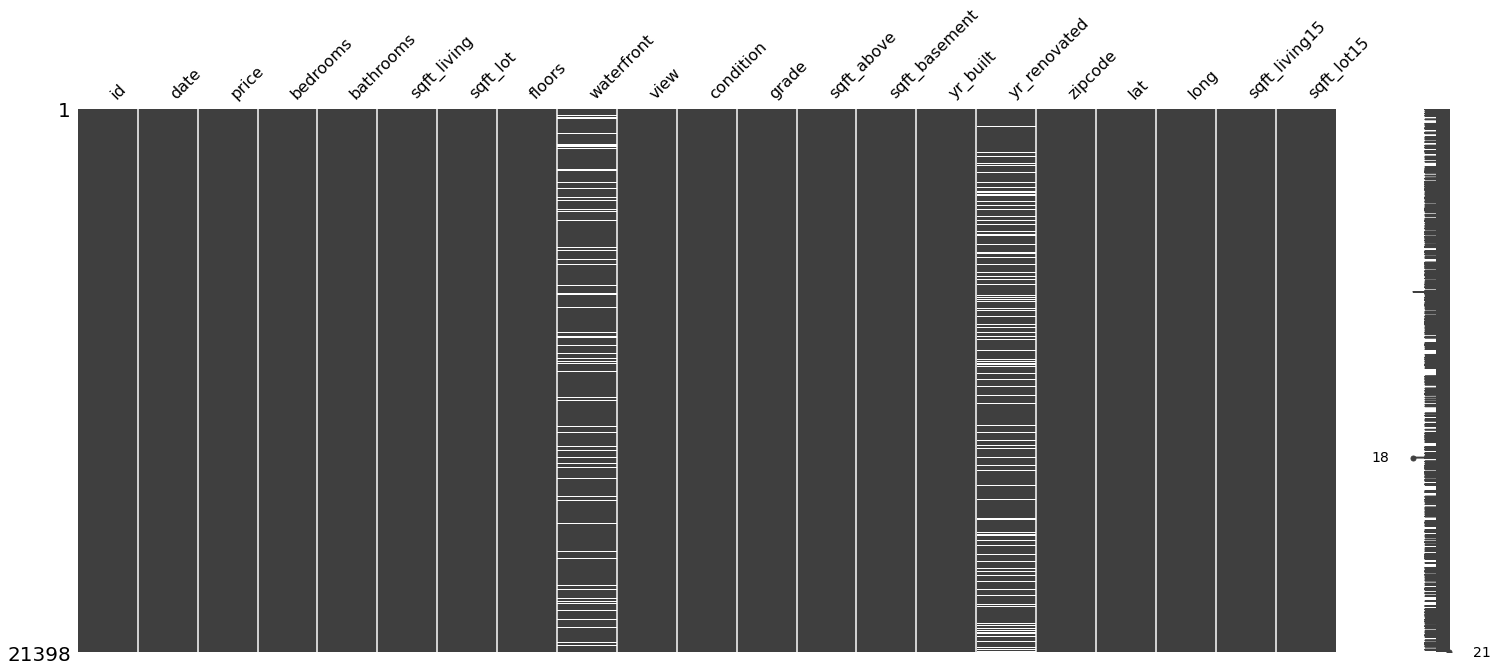

In [20]:
# Visualize where the nulls fall
msno.matrix(df);

There doesn't appear to be any regular pattern with respect to nulls across the few columns where I have them.

For all 3 columns, will replace nulls with 0s, assuming these properties don't have a record of renovation, don't have waterfront access, or don't have a view.

In [21]:
# replace nans with 0s for cols with nulls
for col in cols_w_nulls:
    df.loc[df[col].isna(), col] = 0

In [22]:
# check that it worked
print_uniques(df, cols_w_nulls)

yr_renovated
[   0. 1934. 1940. 1944. 1945. 1946. 1948. 1950. 1951. 1953. 1954. 1955.
 1956. 1957. 1958. 1959. 1960. 1962. 1963. 1964. 1965. 1967. 1968. 1969.
 1970. 1971. 1972. 1973. 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981.
 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993.
 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005.
 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]

waterfront
[0. 1.]

view
[0. 1. 2. 3. 4.]



In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21398 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21398 non-null  int64         
 1   date           21398 non-null  datetime64[ns]
 2   price          21398 non-null  float64       
 3   bedrooms       21398 non-null  int64         
 4   bathrooms      21398 non-null  float64       
 5   sqft_living    21398 non-null  int64         
 6   sqft_lot       21398 non-null  int64         
 7   floors         21398 non-null  float64       
 8   waterfront     21398 non-null  float64       
 9   view           21398 non-null  float64       
 10  condition      21398 non-null  int64         
 11  grade          21398 non-null  int64         
 12  sqft_above     21398 non-null  int64         
 13  sqft_basement  21398 non-null  float64       
 14  yr_built       21398 non-null  int64         
 15  yr_renovated   2139

Now all of my columns are fully populated, with no duplicates or nulls, and are the data type I want.

Let's loop through each column and get a little summary to understand which we might want to turn into categories.

# EXPLORE

In [24]:
def explore_data(to_explore, df, target, hist=True, box=True, plot_v_target=True,
                 summarize=True, norm_check=True):
    """Creates plots and summary information intended to be useful in preparing
    for linear regerssion modeling. Prints plots of distributions, a scatter
    plot of each predictor column against a target, and outputs a dataframe of
    metadata including results of a normality check and correlation coefficient.
    
    Keyword arguments:
    
    to_explore: list of column names to explore
    
    df: Dataframe containing the columns in to_explore, as well as the target
        column
    
    target: string of the column name to use as the target, or dependent variable
    
    hist: True or False (default True). Whether to include a histogram for each
    predictor column.
    
    box: True or False (default True). Whether to include a box plot for each
    predictor column.
    
    plot_v_target: True or False (default True). Whether to include a scatter 
    plot showing the predictor versus target
    
    summarize: True or False (default True). Whether to include a summary of
    the values in each predictor column. Data will be summarized using 
    df.describe() for variables deemed continuous, and df.sort_values()
    for variables deemed categorical. Classification of continuous versus
    categorical is best effort.
    
    norm_check: True or False (default True). Whether to perform a normality
    check using SciPy's stats omnibus normality test. Null hypothesis 
    is that the data comes from a normal distribution, so a value less than
    0.05 represents likely NOT normal data.
    """
    
    # Create some variables to dynamically handle including/excluding 
    # certain charts
    num_charts = 0
    if hist:
        num_charts += 1
    if box:
        num_charts += 1 
    if plot_v_target:
        num_charts += 1
        
    # check if input column is a list; if not, make it one. This allows for
    # a string to be passed if only one column is being summarized.
    if type(to_explore) == str:
        temp_list = [to_explore]
        to_explore = temp_list
    
    # column headers for metadata output df
    meta_list = [['col_name', 'corr_target', 'assumed_var_type', 'omnibus_k2',
                 'omnibus_pstat', 'is_normal', 'uniques', 'mean', 'median']]
    
    # loop through each column in the list to analyze
    for col in to_explore:
        
        header_line = '-'*75
        header_text = f'\nSummary of Data for column: {col}\n'
        print(header_line + header_text + header_line)
        
        # Determine if categorical or continuous
        # assume continuous to begin with
        var_type = 'continuous'
        data_type = df[col].dtype
        uniques = np.nan
        mean = np.nan
        median = np.nan
        num_uniques = len(df[col].unique())
        
        if df[col].dtype in ['int64', 'float64']:
            # number types need the most analysis because they could be
            # categorical even if they're numeric
            
            # using 100 as an arbitrary cutoff here, may need adjustment
            if num_uniques < 20:
                var_type = 'categorical'
                uniques = num_uniques
            else:
                mean = np.mean(df[col])
                median = np.median(df[col])
        elif df[col].dtype in ['object']:
            # Assuming column types have been fixed at this point,
            # so if a column is not numerical it must be categorical
            var_type = 'categorical'
            uniques = num_uniques
        elif df[col].dtype in ['datetime64']:
            var_type = 'date'
            
        # print summary based on data type
        if summarize:
            if var_type in ['continuous', 'date']:
                print(df[col].describe())
            else:
                with pd.option_context('display.max_rows', 20):
                    print(df[col].value_counts())
        
        # currently only creates scatter plots on numerical data
        if data_type in ['int64', 'float64']:
            if num_charts > 0:

                fig, axes = plt.subplots(nrows=num_charts, ncols=1, 
                                         figsize=(8, num_charts * 5))
                if hist:
                    if num_charts > 1:
                        ax1 = axes[0]
                    else:
                        ax1 = axes

                    if box:
                        ax2 = axes[1]
                        if plot_v_target:
                            ax3 = axes[2]
                    elif plot_v_target:
                        ax3 = axes[1]
                elif box:
                    if num_charts > 1:
                        ax2 = axes[0]
                    else:
                        ax2 = axes

                    if plot_v_target:
                        ax3 = axes[1]

                elif plot_v_target:
                    ax3 = axes


                # add a little extra space for headers
                plt.subplots_adjust(hspace=0.3)

                # Histogram
                if hist:
                    sns.histplot(df[col], kde=True, ax=ax1)
                    ax1.set_title(f"Hist {col}")

                # Box plot
                if box:
                    sns.boxplot(x=df[col], ax=ax2)
                    ax2.set_title(f"Boxplot {col}")

                # Plot against target
                # create a series representing quartiles, to use as hue
                if plot_v_target:                
                    if var_type == 'continuous':
                        try:
                            quartile_labels=['q1', 'q2', 'q3', 'q4']
                            quartiles = pd.qcut(df[col], 4, labels=quartile_labels, duplicates='drop')
                            sns.scatterplot(x=df[col], y=df[target], ax=ax3, hue=quartiles)
                            ax3.legend(title=f'{col} quartiles')
                            
                        except:
                            sns.scatterplot(x=df[col], y=df[target], ax=ax3)
                    else:
                        sns.scatterplot(x=df[col], y=df[target], ax=ax3)
                    ax3.set_title(f"{col} versus {target}")

                plt.show();

            # get pearson correlation coefficient between col and target
            corr = df[[col, target]].corr()

            # Test for normality using scipy omnibus normality test
            # null hypothesis is that the data comes from a normal distribution
            if norm_check:
                k2, p = stats.normaltest(df[col])
                if p < 0.05:
                    normal = False
                    print(f'\nData is NOT normal with p-value = {p}\n')
                else:
                    normal = True
                    print(f'\nData IS normal with p-value = {p}\n')

            # append metadata to list of lists
            meta_list.append([col, corr.iloc[0][1], var_type, k2, p, normal, 
                uniques, mean, median])
        
    df_meta = pd.DataFrame(data=meta_list[1:], columns=meta_list[0])
    return df_meta
    

## Run initial column summary reports and graphs

---------------------------------------------------------------------------
Summary of Data for column: price
---------------------------------------------------------------------------
count    2.139800e+04
mean     5.418163e+05
std      3.677075e+05
min      7.800000e+04
25%      3.248910e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64


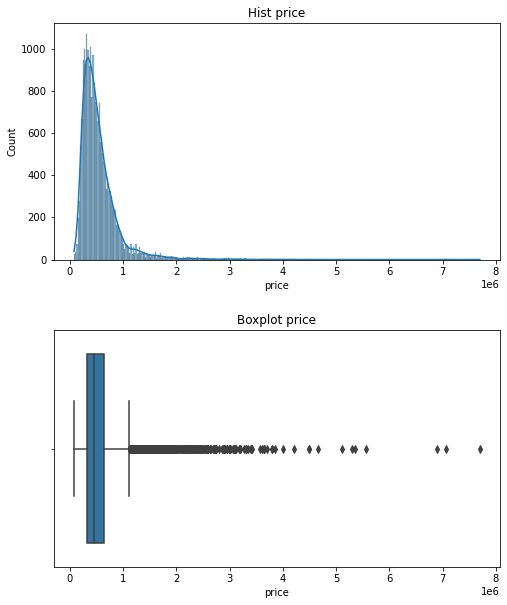


Data is NOT normal with p-value = 0.0



,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,price,1.0,continuous,18964.89715,0.0,False,NaN,541816.346107,450000.0


In [25]:
# First, let's see what price looks like
explore_data('price', df, 'price', plot_v_target=False)

Price is very right-skewed and has many outliers. Median is quite different from mean.

Let's see how the other variables correlate to it with all the outliers left in.

In [26]:
# Dropping columns I do not plan to explore at this time
explore_cols = df.drop(labels=['price', 'lat', 'long', 'id', 'date', 
                                   'sqft_living15', 'sqft_lot15'], axis=1
                          ).columns
explore_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode'],
      dtype='object')

---------------------------------------------------------------------------
Summary of Data for column: bedrooms
---------------------------------------------------------------------------
3     9724
4     6844
2     2729
5     1583
6      265
1      191
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64


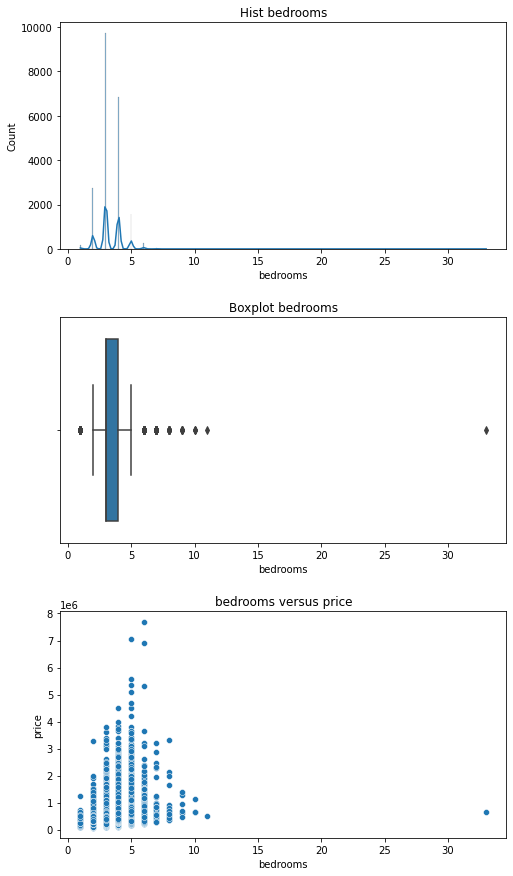


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: bathrooms
---------------------------------------------------------------------------
count    21398.000000
mean         2.118399
std          0.768584
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64


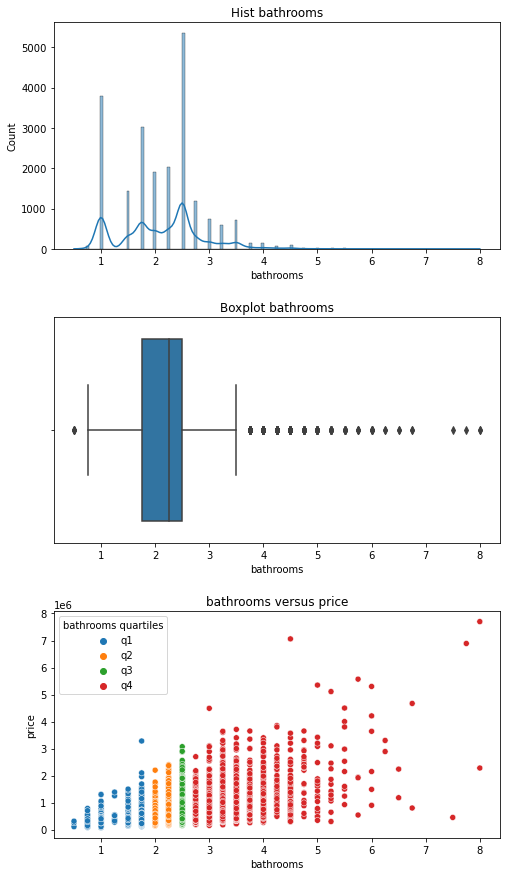


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: sqft_living
---------------------------------------------------------------------------
count    21398.000000
mean      2083.167165
std        918.858422
min        370.000000
25%       1430.000000
50%       1920.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64


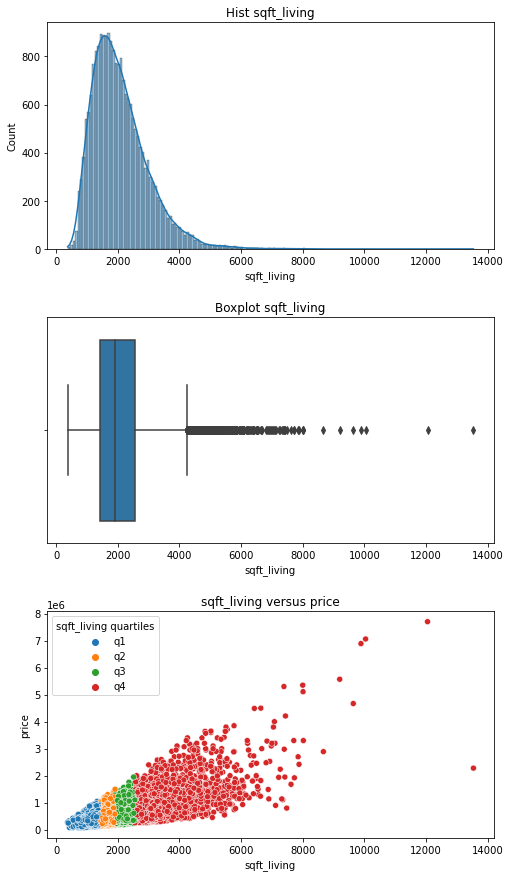


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: sqft_lot
---------------------------------------------------------------------------
count    2.139800e+04
mean     1.513835e+04
std      4.155080e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.617000e+03
75%      1.069775e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64


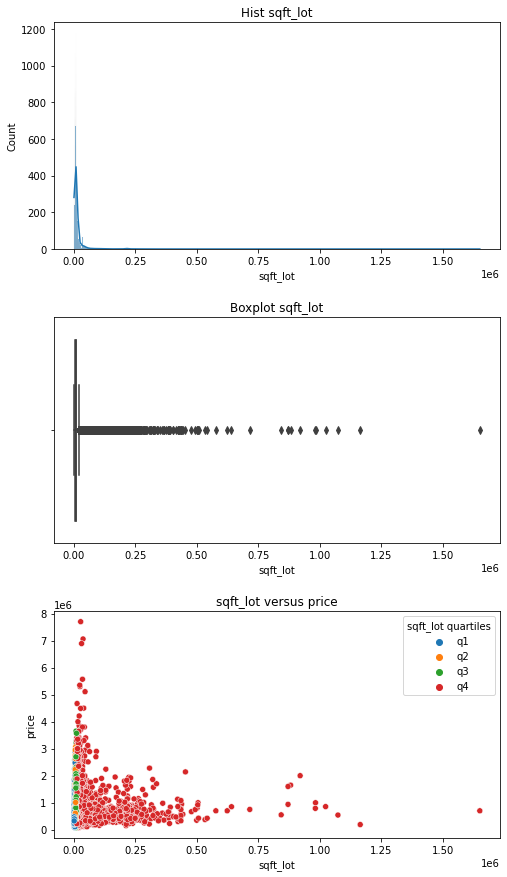


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: floors
---------------------------------------------------------------------------
1.0    10544
2.0     8192
1.5     1887
3.0      607
2.5      161
3.5        7
Name: floors, dtype: int64


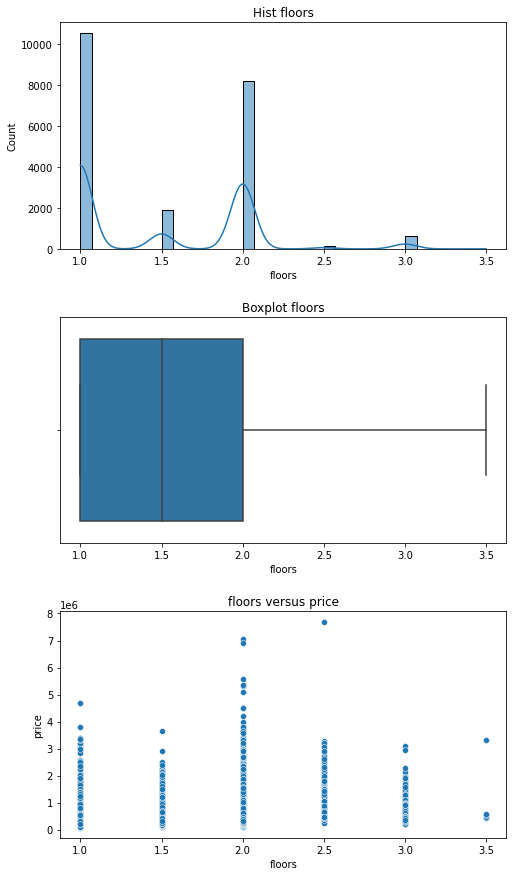


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: waterfront
---------------------------------------------------------------------------
0.0    21252
1.0      146
Name: waterfront, dtype: int64


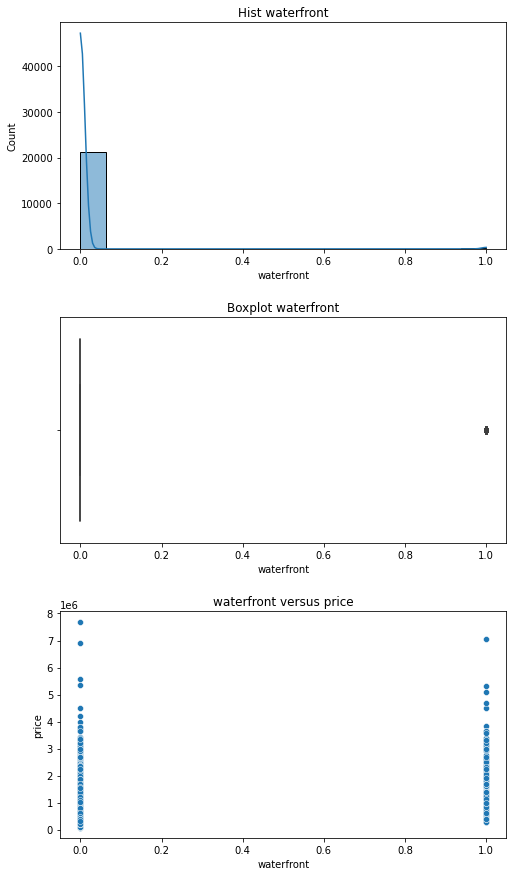


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: view
---------------------------------------------------------------------------
0.0    19295
2.0      955
3.0      505
1.0      329
4.0      314
Name: view, dtype: int64


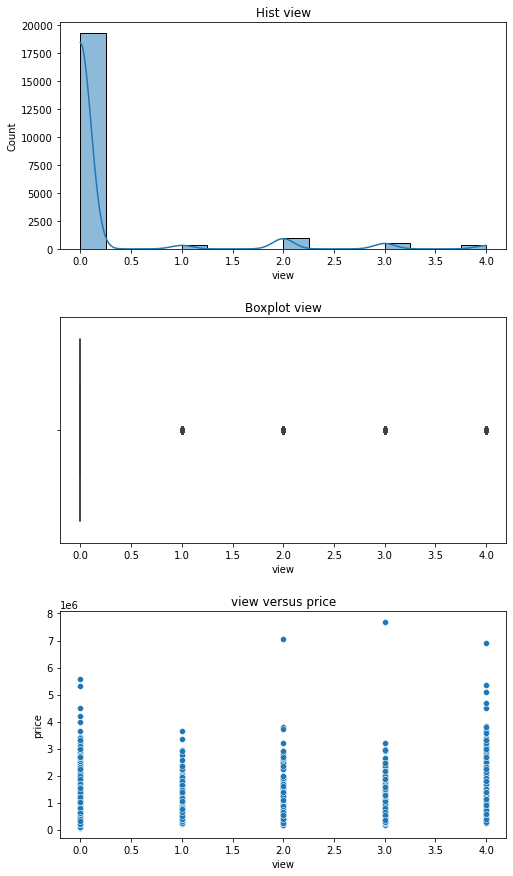


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: condition
---------------------------------------------------------------------------
3    13882
4     5640
5     1687
2      161
1       28
Name: condition, dtype: int64


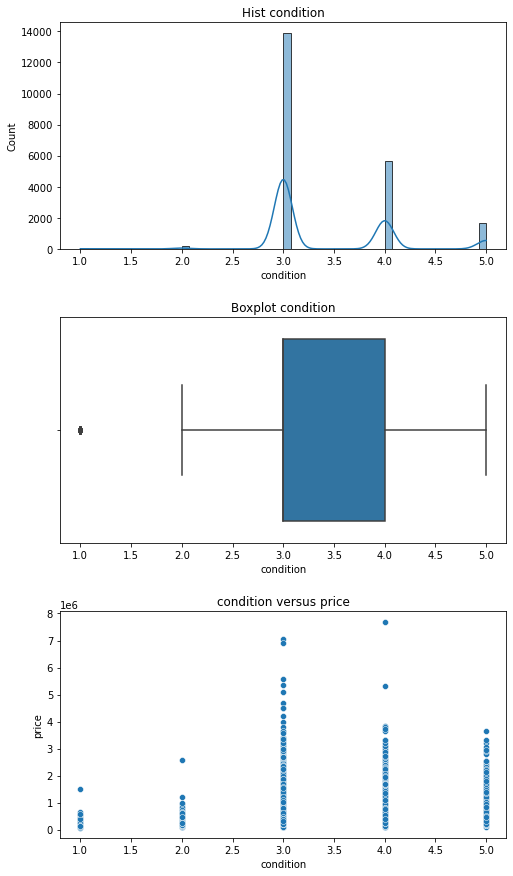


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: grade
---------------------------------------------------------------------------
7     8883
8     6034
9     2600
6     1992
10    1130
11     396
5      234
12      88
4       27
13      13
3        1
Name: grade, dtype: int64


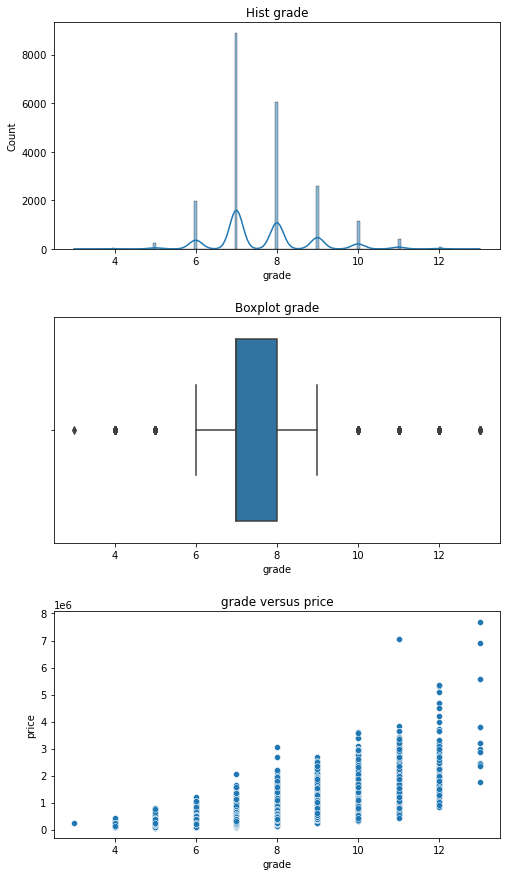


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: sqft_above
---------------------------------------------------------------------------
count    21398.000000
mean      1791.015796
std        828.577965
min        370.000000
25%       1200.000000
50%       1560.000000
75%       2220.000000
max       9410.000000
Name: sqft_above, dtype: float64


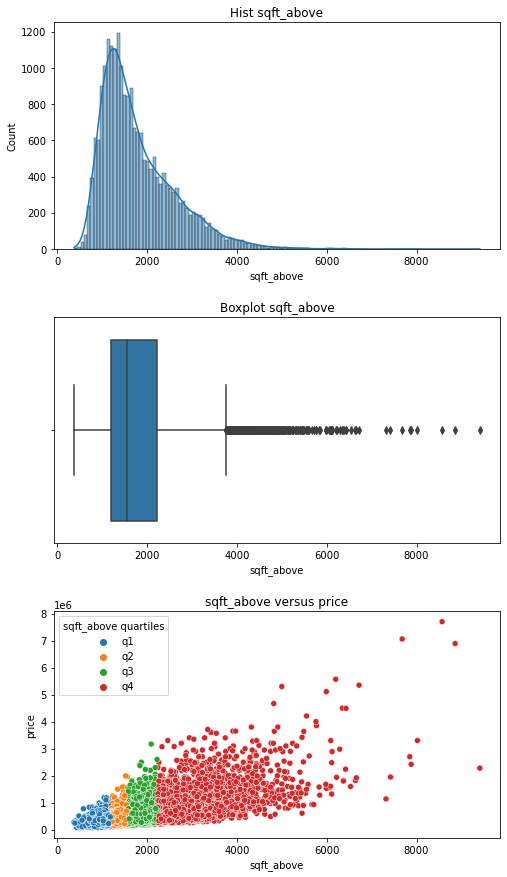


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: sqft_basement
---------------------------------------------------------------------------
count    21398.000000
mean       286.119778
std        440.152243
min          0.000000
25%          0.000000
50%          0.000000
75%        550.000000
max       4820.000000
Name: sqft_basement, dtype: float64


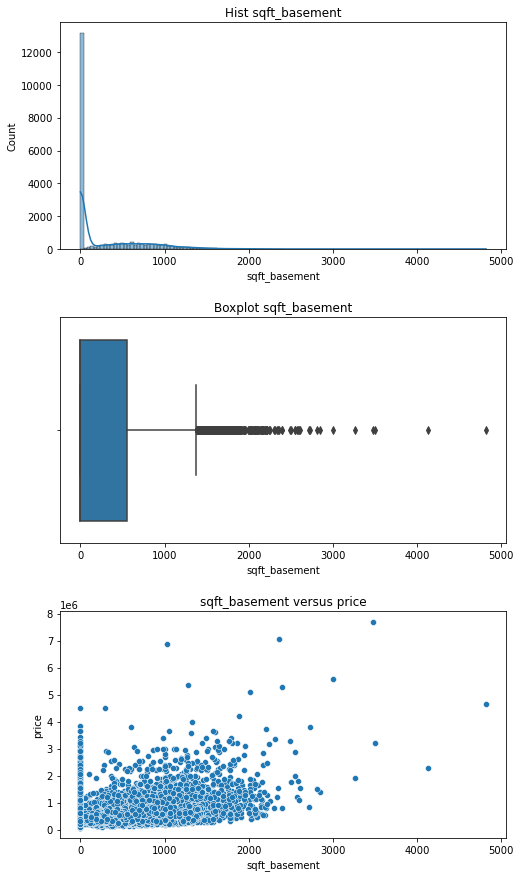


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: yr_built
---------------------------------------------------------------------------
count    21398.000000
mean      1971.083886
std         29.375124
min       1900.000000
25%       1952.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64


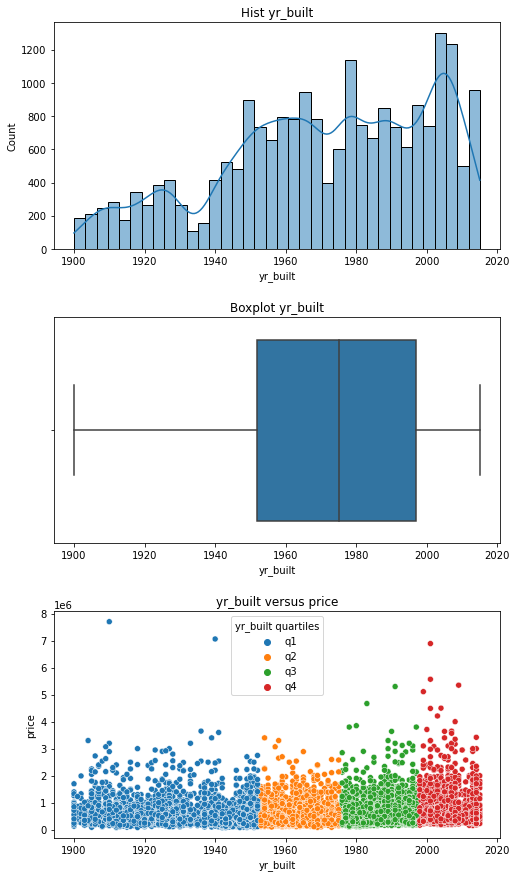


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: yr_renovated
---------------------------------------------------------------------------
count    21398.000000
mean        68.934340
std        364.495271
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64


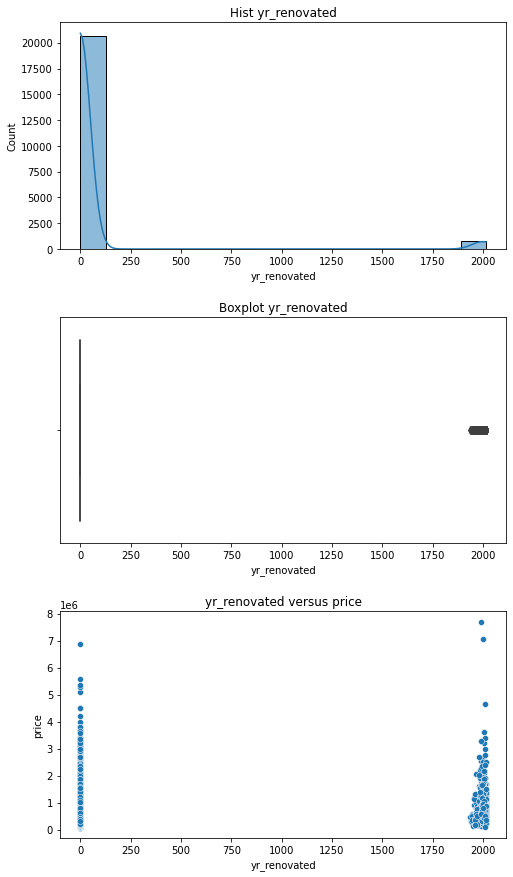


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: zipcode
---------------------------------------------------------------------------
count    21398.000000
mean     98077.869941
std         53.489768
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98117.000000
max      98199.000000
Name: zipcode, dtype: float64


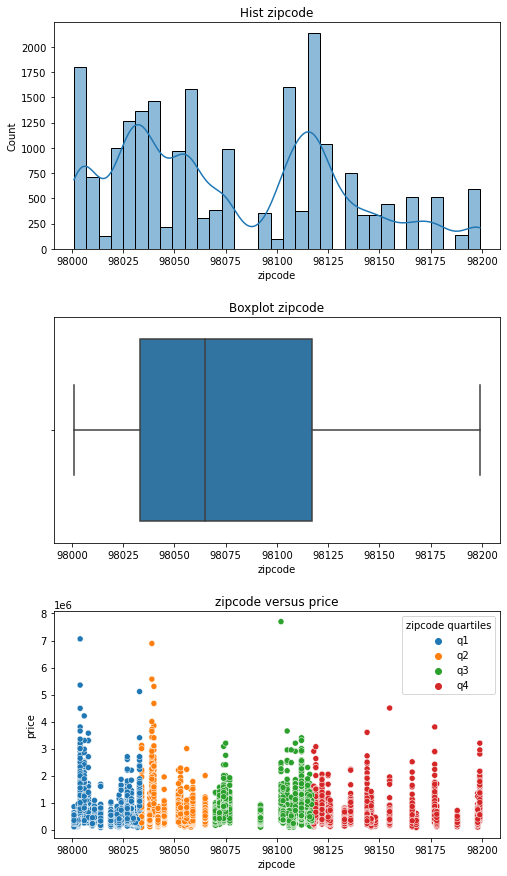


Data is NOT normal with p-value = 0.0



In [27]:
# Run explore function for initial set of columns on data with
# outliers still left in

df_meta = explore_data(explore_cols, df, 'price')

In [28]:
df_meta.sort_values('corr_target', ascending=False)

,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
2,sqft_living,0.701447,continuous,6798.561480,0.0,False,NaN,2083.167165,1920.00
8,grade,0.666942,categorical,2239.807458,0.0,False,11.0,NaN,NaN
9,sqft_above,0.604557,continuous,5952.212235,0.0,False,NaN,1791.015796,1560.00
1,bathrooms,0.525399,continuous,1439.840714,0.0,False,NaN,2.118399,2.25
6,view,0.392932,categorical,14728.882977,0.0,False,5.0,NaN,NaN
10,sqft_basement,0.321462,continuous,6263.218160,0.0,False,NaN,286.119778,0.00
0,bedrooms,0.309591,categorical,13574.044301,0.0,False,12.0,NaN,NaN
5,waterfront,0.264953,categorical,36132.089117,0.0,False,2.0,NaN,NaN
4,floors,0.254958,categorical,1536.123350,0.0,False,6.0,NaN,NaN
12,yr_renovated,0.118379,continuous,20849.859790,0.0,False,NaN,68.934340,0.00


## Feature Engineering

### Bedrooms

In [29]:
# Bedrooms looks to have an extreme outlier
df[df['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [30]:
# Dropping this outlier because it looks like the info was recorded incorrectly
df.drop(labels=df[df['bedrooms'] == 33].index, axis=0, inplace=True)

df[df['bedrooms'] == 33]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


---------------------------------------------------------------------------
Summary of Data for column: bedrooms
---------------------------------------------------------------------------
3     9724
4     6844
2     2729
5     1583
6      265
1      191
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64


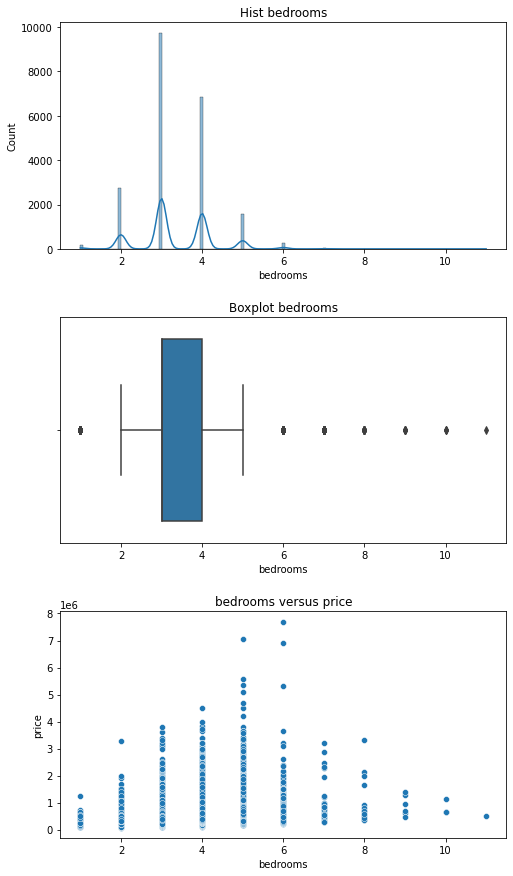


Data is NOT normal with p-value = 0.0



,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,bedrooms,0.316877,categorical,1840.008483,0.0,False,11,NaN,NaN


In [31]:
# Review summary again with one outlier dropped
explore_data(['bedrooms'], df, 'price')

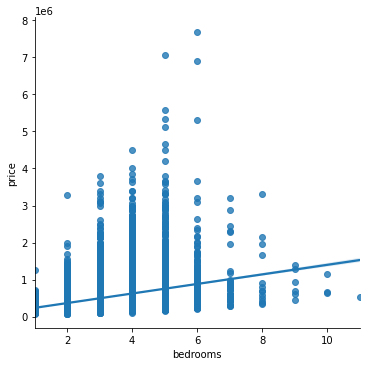

In [32]:
# Run a lmplot to check assumption of linear relationship
g = sns.lmplot(data=df, x='bedrooms', y='price')


There is a slight linear relationship between bedrooms and price. It's not a lot, but I think enough to keep it in my initial model and see how it does.

### Bathrooms

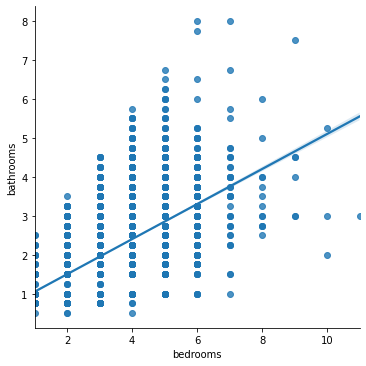

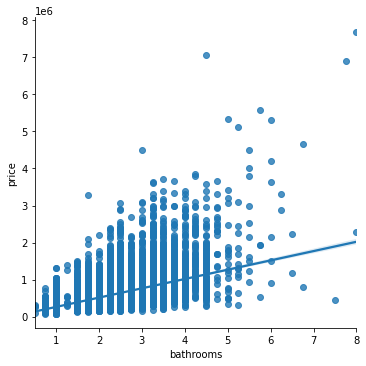

In [33]:
## Plot bathrooms versus bedrooms to try to identify outliers or bad data
# I believe they should more or less correlate
sns.lmplot(data=df, x='bedrooms', y='bathrooms')

# check linearity between bathrooms and price
sns.lmplot(data=df, x='bathrooms', y='price')

Some of these certainly sound weird to me (a 6-bedroom house with 8 bathrooms?) but not totally outside the realm of possibility.

I see a linear relationship between bathrooms and price, so going to use in the model. Also not going to make this categorical to preserve the notion of having a half or 3/4 bath.

### Sq Ft Living

In [34]:
df[df['sqft_living'] < 500]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
465,8658300340,2014-05-23,80000.0,1,0.75,430,5050,1.0,0.0,0.0,...,4,430,0.0,1912,0.0,98014,47.6499,-121.909,1200,7500
860,1723049033,2014-06-20,245000.0,1,0.75,380,15000,1.0,0.0,0.0,...,5,380,0.0,1963,0.0,98168,47.4810,-122.323,1170,15000
1166,3523029041,2014-10-09,290000.0,2,0.75,440,8313,1.0,1.0,3.0,...,5,440,0.0,1943,0.0,98070,47.4339,-122.512,880,26289
4199,1437500015,2014-07-09,150000.0,3,0.75,490,38500,1.5,0.0,0.0,...,5,490,0.0,1959,0.0,98014,47.7112,-121.315,800,18297
8126,7849202585,2014-09-04,170000.0,1,1.00,480,4560,1.0,0.0,0.0,...,5,480,0.0,1922,0.0,98065,47.5253,-121.826,890,4803
8614,6303400395,2015-01-30,325000.0,1,0.75,410,8636,1.0,0.0,0.0,...,4,410,0.0,1953,0.0,98146,47.5077,-122.357,1190,8636
11488,4322200105,2015-03-31,229050.0,1,1.00,420,3298,1.0,0.0,0.0,...,4,420,0.0,1949,0.0,98136,47.5375,-122.391,1460,4975
12063,8655900162,2015-02-19,156000.0,1,0.75,470,15000,1.0,0.0,0.0,...,4,470,0.0,1947,0.0,98014,47.6554,-121.908,1730,22500
14452,7549801385,2014-06-12,280000.0,1,0.75,420,6720,1.0,0.0,0.0,...,5,420,0.0,1922,0.0,98108,47.5520,-122.311,1420,6720
15234,1320069249,2014-10-20,192500.0,1,1.00,470,63737,1.0,0.0,2.0,...,5,470,0.0,1924,0.0,98022,47.2163,-121.984,1350,46762


Checking out houses under 500 sq ft. These could be tiny houses or mobile homes, so I don't see any reason to remove them.

Sq Ft living definitely has a linear relationship to price.

### Sq Ft Lot

In [35]:
# Review quartiles for sq ft lot
df['sqft_lot'].quantile(q=[0, .25, .5, .75, 1])

0.00        520.0
0.25       5040.0
0.50       7617.0
0.75      10698.0
1.00    1651359.0
Name: sqft_lot, dtype: float64

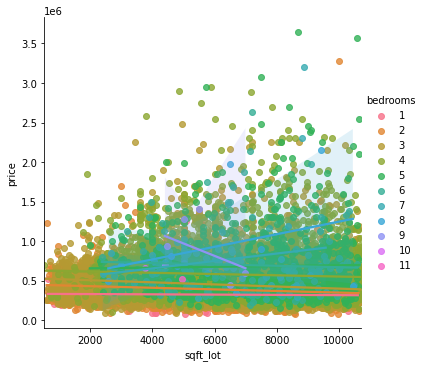

In [36]:
# Explore possible linear relationship between sq ft lot and 
# Price, per bedroom, and removing the 4th quartile
sns.lmplot(data=df[df['sqft_lot'] <= 10698.0], x='sqft_lot', y='price', 
           hue='bedrooms')

I actually don't see much of a linear relationship, for houses with reasonable number of bedrooms, even if I remove the 4th quartile (which seemed to be creating a lot of noise in my initial plot. Since there isn't a clear linear relationship with price, I'm not going to include in my model.

### Floors

In [37]:
# Check out houses with half floors, do they have basements?
df_floors = df.loc[df['floors'].isin([1.5, 2.5, 3.5]) == True, 
                       ['floors','sqft_basement']].copy()

temp = df_floors['sqft_basement'] > 0
temp.value_counts()

False    1263
True      792
Name: sqft_basement, dtype: int64

Some of the houses that have half floors also have basement sq footage, but most do not. Going to adjust the floors to round down to nearest whole number.

In [38]:
# round floor down to nearest whole number
df['floors'] = df['floors'].map(lambda x: int(x))

In [39]:
# check values
df['floors'].value_counts()

1    12430
2     8353
3      614
Name: floors, dtype: int64

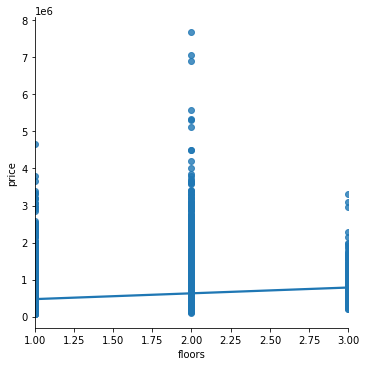

In [40]:
# Investigate linear relationship between new floor and price
sns.lmplot(data=df, x='floors', y='price');

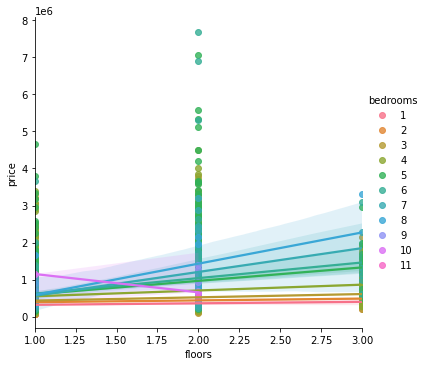

In [41]:
sns.lmplot(data=df, x='floors', y='price', hue='bedrooms');

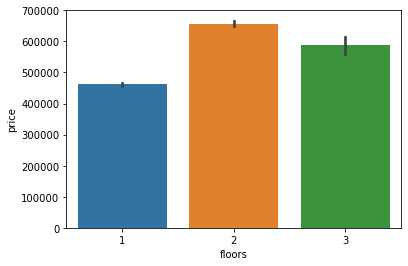

In [42]:
sns.barplot(data=df, x='floors', y='price', );

There is very little linear relationship between floors and price overall. When I plot the number of bedrooms separately I see that there is more of a linear relationship the more bedrooms a house has.

I may consider keeping this in as a categorical variable.

### View

In [43]:
# convert to binary yes/no, since I don't have informatino on what
# the individual view numbers mean
df['view'] = df['view'].map(lambda x: 1 if x > 0 else 0)
df['view'].value_counts()

0    19294
1     2103
Name: view, dtype: int64

There aren't a lot of houses that have a view, but I would like to explore how it affects price in my model. Since this is now a categorical variable, I'm not concerned with a linear relationship.

### Condition

In [44]:
df['condition'].value_counts()

3    13882
4     5640
5     1686
2      161
1       28
Name: condition, dtype: int64

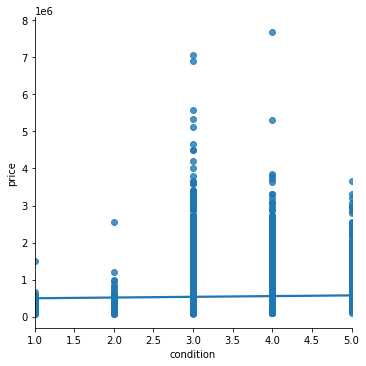

In [45]:
sns.lmplot(data=df, x='condition', y='price');

Not much linear relationship when I use condition as a continuous variable. But I have a suspicion it does have some impact on price. The vast majority of homes are in average condition (3), with only a few being below average, and a decent amount being above average.

I will convert to a categorical variable representing average, below average, and above average so I can include it in my model to see what effect it has.

In [46]:
# Create a new column indicating over or under average condition
df['condition_new'] = df['condition'].map(lambda x : 'Above Average' if x > 3 
                        else ('Below Average' if x < 3 else 'Average'))

print(df['condition_new'].value_counts())
print(f"Null count {df['condition_new'].isna().sum()}")

Average          13882
Above Average     7326
Below Average      189
Name: condition_new, dtype: int64
Null count 0


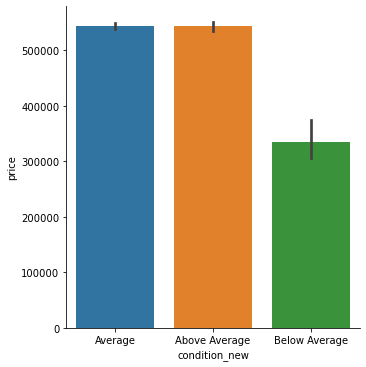

In [47]:
# plot new condition against price
sns.catplot(data=df, x='condition_new', y='price', kind='bar');

So being average or above average may not affect price much, but being below average might.

### Sq Ft Basement

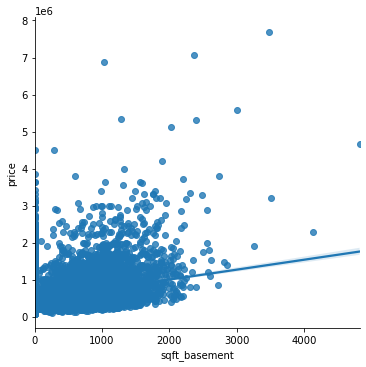

In [48]:
sns.lmplot(data=df, x='sqft_basement', y='price');

Despite the fact that many houses don't have any basements at all, there does seem to be some linear relationship between price and basement sq ft.

However, I'm skeptical that houses with more square foot in their basement will fetch higher prices. I'm going to create a categorical variable for has basement so I can try that out too.

In [49]:
## Convert to has basement yes/no
df['has_basement'] = df['sqft_basement'].map(lambda x : 1 if x > 0 else 0)
df['has_basement'].value_counts()

0    13151
1     8246
Name: has_basement, dtype: int64

In [50]:
# Does sqft_basement represent both finished and unfinished? or just finished?
# check whether sqft_above and sqft_basement = sqft_living to test this
ab_sum = df['sqft_above'] + df['sqft_basement']

np.allclose(ab_sum, df['sqft_living'])

False

In [51]:
# review the data points where above and basement don't equal living
df.loc[df['sqft_above'] + df['sqft_basement'] != df['sqft_living'] , 
           ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'long', 'price']]

,sqft_living,sqft_above,sqft_basement,lat,long,price
112,1540,1160,0.0,47.3624,-122.031,272500.0
115,4380,2780,0.0,47.6981,-122.368,740500.0
309,3320,2220,0.0,47.5376,-122.180,665000.0
384,4800,3480,0.0,47.5543,-122.148,1350000.0
508,1540,820,0.0,47.6454,-122.373,615000.0
...,...,...,...,...,...,...
21000,1410,1290,0.0,47.5344,-122.068,379500.0
21109,2910,2040,0.0,47.5543,-122.359,515000.0
21210,1170,1070,0.0,47.5493,-122.372,235000.0
21356,4460,3280,0.0,47.6313,-122.370,490000.0


I'm not sure how to interpret these; looked up one house and the figures didn't match what I see here. sqft_living did appear to equal the finished square footage including a basement, but sqft_above wasn't right. Since there are only 169 instances of this discrepancy, I'm going to drop these records. 

For the rest of the records, I'll assume that sqft_living represents the FINISHED sq footage, and sqft_basement represents FINISHED BASEMENT so if a property has an unfinished basement, those sqft are not counted here.

In [52]:
# drop rows where sqft_above + sqft_basement do not add up to sqft_living
df.drop(index=df[df['sqft_above'] + df['sqft_basement'] 
                         != df['sqft_living']].index, inplace=True)

### Yr Renovated

In [53]:
df['yr_renovated'].value_counts()

0.0       20499
2014.0       71
2003.0       31
2013.0       31
2007.0       30
          ...  
1959.0        1
1953.0        1
1944.0        1
1950.0        1
1971.0        1
Name: yr_renovated, Length: 70, dtype: int64

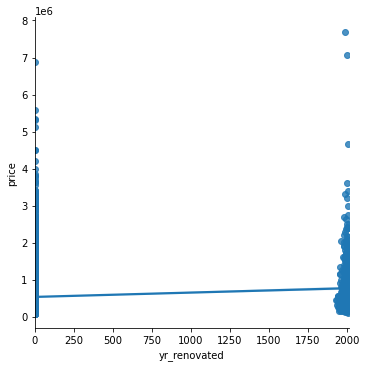

In [54]:
sns.lmplot(data=df, x='yr_renovated', y='price');

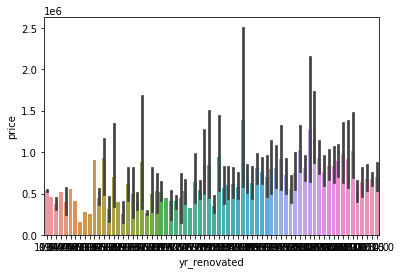

In [55]:
sns.barplot(data=df, x='yr_renovated', y='price');

Most houses don't have any year listed for last renovated, and I don't see much of a linear relationship.

Looking at the bar plot, there may be a slight increase in price for houses which were renovated later, but not much.

In [56]:
# Create feature for years since renovation, or since built if never renovated
df['year_sold'] = df['date'].dt.year

def years_since_reno(row):
    #print(row)
    if row['yr_renovated'] > 0:
        years = row['year_sold'] - row['yr_renovated']
    else:
        years = row['year_sold'] - row['yr_built']
    return years

df['years_since_reno'] = df.apply(lambda x: years_since_reno(x), axis=1)

df['years_since_reno'].value_counts()

 9.0      488
 0.0      485
 8.0      476
 11.0     456
 10.0     449
         ... 
 113.0     26
 115.0     23
-1.0       17
 81.0      16
 80.0      15
Name: years_since_reno, Length: 117, dtype: int64

In [57]:
# check out these negative values, figuring these are within same year
df[df['years_since_reno'] < 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,condition_new,has_basement,year_sold,years_since_reno
1761,1832100030,2014-06-25,597326.0,4,4.00,3570,8250,2,0.0,0,...,0.0,98040,47.5784,-122.226,2230,10000,Average,1,2014,-1.0
2293,8712100320,2014-07-28,585000.0,5,2.75,2350,4178,1,0.0,0,...,2015.0,98112,47.6388,-122.300,1920,4178,Average,1,2014,-1.0
2685,3076500830,2014-10-29,385195.0,1,1.00,710,6000,1,0.0,0,...,0.0,98144,47.5756,-122.316,1440,4800,Average,0,2014,-1.0
7090,9141100005,2014-10-28,285000.0,4,3.50,2770,10505,2,0.0,0,...,2015.0,98133,47.7412,-122.355,1760,10505,Average,0,2014,-1.0
7519,9520900210,2014-12-31,614285.0,5,2.75,2730,6401,2,0.0,0,...,0.0,98072,47.7685,-122.160,2520,6126,Average,0,2014,-1.0
8032,1250200495,2014-06-24,455000.0,2,1.50,1200,1259,2,0.0,0,...,0.0,98144,47.6001,-122.298,1320,1852,Average,1,2014,-1.0
11587,7284900030,2014-05-22,850000.0,4,3.25,3090,6744,2,0.0,1,...,2015.0,98177,47.7680,-122.388,2020,6656,Average,0,2014,-1.0
14475,2770601530,2014-08-26,500000.0,2,2.25,1570,1269,2,0.0,0,...,0.0,98199,47.6514,-122.385,1570,6000,Average,1,2014,-1.0
14845,3585900665,2014-06-06,805000.0,5,2.50,4600,19831,1,0.0,1,...,2015.0,98177,47.7608,-122.378,2890,19831,Average,1,2014,-1.0
15673,3585900190,2014-10-06,825000.0,3,2.50,3400,38400,1,0.0,1,...,2015.0,98177,47.7611,-122.372,3400,24338,Average,1,2014,-1.0


In [58]:
# update years_since_reno to be 0 when negative
df.loc[df['years_since_reno'] < 0, ['years_since_reno']] = 0
df['years_since_reno'].value_counts()

0.0      502
9.0      488
8.0      476
11.0     456
10.0     449
        ... 
79.0      31
113.0     26
115.0     23
81.0      16
80.0      15
Name: years_since_reno, Length: 116, dtype: int64

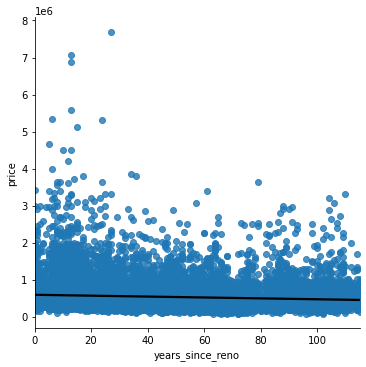

In [59]:
# Plot years_since_reno against price
sns.lmplot(data=df, x='years_since_reno', y='price', line_kws={'color':'black'});

Even with the new Years since Reno feature, I don't see much linear relationship. Not going to include in my model.

## Columns to Keep or Drop

I'm only going to consider including predictors in my model that had some sort of linear relationship with price, or that will be categorical so that a linear relationship isn't necessary.

The following variables have a linear relationship and will be kept in the initial model as continuous variables:
- sq ft living
- sq ft above
- sq ft basement
- grade
- bedrooms
- bathrooms

The following variables will be categorical:
- zip code
- condition
- has_basement
- view
- waterfront
- floors

The following variables do not appear to have a linear relationship, and I'll exclude them for now.
- sq ft lot
- yr renovated (and my feature years_since_reno)
- yr built

I'm also not going to explore the following variables
- date (we don't have data over a long enough time period to be useful)
- lat and long
- sqft_living15 and sqft_lot15


In [60]:
to_drop = ['lat', 'long', 'id', 'date', 'sqft_living15', 
           'sqft_lot15', 'year_sold', 'sqft_lot', 'yr_renovated',
           'yr_built', 'years_since_reno']

# Create a backup of columns to drop, in case I want to come back later
df_dropped = df[to_drop]

# drop these columns from working dataframe to continue
df.drop(to_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21228 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21228 non-null  float64
 1   bedrooms       21228 non-null  int64  
 2   bathrooms      21228 non-null  float64
 3   sqft_living    21228 non-null  int64  
 4   floors         21228 non-null  int64  
 5   waterfront     21228 non-null  float64
 6   view           21228 non-null  int64  
 7   condition      21228 non-null  int64  
 8   grade          21228 non-null  int64  
 9   sqft_above     21228 non-null  int64  
 10  sqft_basement  21228 non-null  float64
 11  zipcode        21228 non-null  int64  
 12  condition_new  21228 non-null  object 
 13  has_basement   21228 non-null  int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 3.1+ MB


## Review Multicollinearity

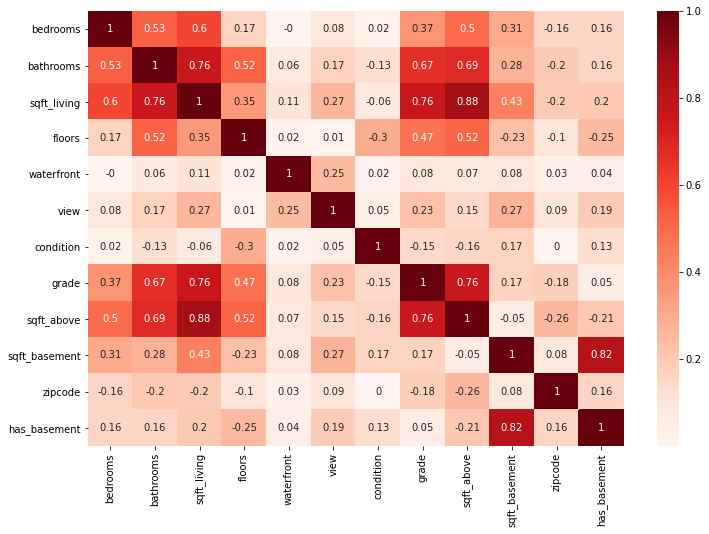

In [61]:
# Correlation matrix for IVs
corr_1 = df.drop('price', axis=1).corr()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(np.abs(corr_1), cmap='Reds', 
            annot=corr_1.apply(lambda x: np.round(x, 2)));

- Sq ft living and sq ft above are highly correlated, which makes sense since they will probably be the same in most cases where the house doesn't have a basement. I'm not going to include sq ft above in my model, just sq ft living.
- I'm also only going to include has_basement or sq ft basement, since they're highly correlated because I engineered one from the other.

- sq ft living and grade also have a fairly high correlation, at 0.76.
- sq ft living and bathrooms have a fairly high correlation as well at 0.76.
- I'm going to leave these in for now.


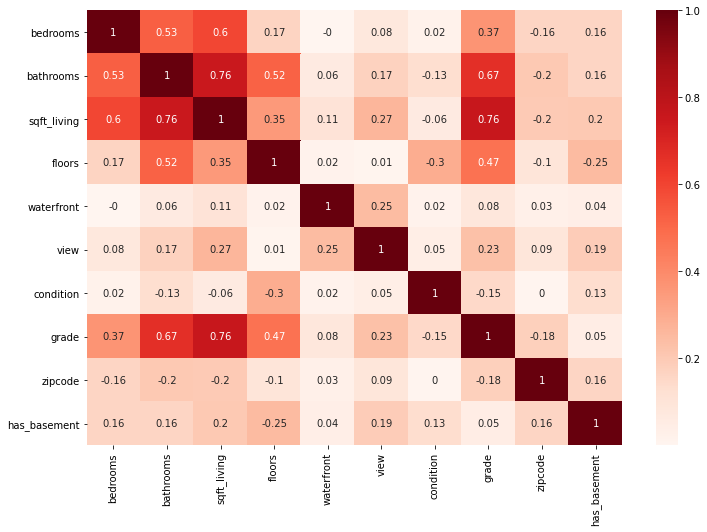

In [62]:
# drop columns I'm not going to include in the model
df.drop(['sqft_above', 'sqft_basement'], axis=1, inplace=True)
        
# Correlation matrix for IVs
corr_1 = df.drop('price', axis=1).corr()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(np.abs(corr_1), cmap='Reds', 
            annot=corr_1.apply(lambda x: np.round(x, 2)));

# MODEL

In [63]:
def iterate_model_sm(target, x_cols, df):
    """Uses statsmodels to fit an OLS linear regression model to data provided.
    Prints the summary of the model, displays a qq-plot to check the normality
    of residuals, and plots predictions against residuals to check for
    homoscedasticity.
    
    Parameters:
    -------------------------
    target: string, name of the column in the dataframe that represents the
    dependent, or target variable.
    
    x_cols: list of column names to be included as independent, or predictor
    variables in the model.
    
    df: Dataframe including x_cols and target column. Any additional columns
    included in df which are not included in x_cols or target will be ignored.
    Data should be standardized and dummied as appropriate before calling this
    function, since it does not perform these tasks.
    """
    
    x_count = 1
    
    # Create formula
    if type(x_cols) == str:
        formula = f'{target}~' + x_cols
    else:
        if len(x_cols) > 1:
            formula = f'{target}~' + '+'.join(x_cols) 
            x_count = len(x_cols)
        else:
            formula = f'{target}~' + x_cols[0]

    # Fit model using statsmodels
    model = ols(formula=formula, data=df).fit()
    print(model.summary())

    # Create a qq plot to check for normality of the residuals
    fig, ax = plt.subplots()
    fig = sm.qqplot(model.resid, dist=stats.norm, line='45', ax=ax, fit=True)
    ax.set_title("QQ Plot for Normality Check")
    plt.show();

    # Plot residuals to check for homoscedasticity
    fig, ax = plt.subplots(figsize=(8, 6))
    if x_count > 1:
        #dummy_x = np.arange(1, len(df)+ 1)
        dummy_x = model.predict(df[x_cols])
        sns.scatterplot(x=dummy_x, y=model.resid, ax=ax)
    else:
        sns.scatterplot(x=df[x_cols], y=model.resid, ax=ax)
    ax.set_title("Residuals Plot for Homoscedasticity")
    plt.axhline(y=0, color='black')
    plt.show();
    
    return model

In [64]:
def eval_vif(df, cols):
    """Calculate VIF scores for columns in a dataframe, 
    and returns a dataframe.
    Taken from https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
    """
    
    vif = pd.DataFrame()
    vif['predictor'] = cols
    vif['vif_score'] = [variance_inflation_factor(df.values, i)
                       for i in range(len(cols))]
    return vif

## Initial model - With outliers

### Preprocessing

In [65]:
# Create dummy columns for zip code and condition using OneHotEncoder
# the other categorical variables are already binary
# drops first category

cols = ['zipcode', 'condition']

ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(df[cols])

cats = pd.DataFrame(ohe.transform(df[cols]), 
                    columns=ohe.get_feature_names(cols))

cats.head()

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,...,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,condition_2,condition_3,condition_4,condition_5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [66]:
# Standardize all the independent variable data to z-scores
df_z = df.drop('price', axis=1)
df_z = (df_z - np.mean(df_z)) / np.std(df_z, ddof=0)

# concatenate standardized IVs with price in dollars
df_z = pd.concat([df['price'], df_z], axis=1)

# reset_index so will line up with cat df properly
df_z.reset_index(drop=True, inplace=True)
df_z.describe()

,price,bathrooms,bedrooms,condition,floors,grade,has_basement,sqft_living,view,waterfront,zipcode
count,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04
mean,5.413635e+05,-2.677757e-16,1.693681e-16,2.195760e-16,3.213308e-17,-1.874430e-16,-3.748859e-17,2.436759e-16,4.686074e-17,-1.807486e-17,4.009572e-14
std,3.677648e+05,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,7.800000e+04,-2.104081e+00,-2.630664e+00,-3.711799e+00,-8.134235e-01,-3.973934e+00,-7.969863e-01,-1.863346e+00,-3.287958e-01,-8.264275e-02,-1.435493e+00
25%,3.240000e+05,-4.776004e-01,-4.113843e-01,-6.307765e-01,-8.134235e-01,-5.645386e-01,-7.969863e-01,-7.092581e-01,-3.287958e-01,-8.264275e-02,-8.371286e-01
50%,4.500000e+05,1.729917e-01,-4.113843e-01,-6.307765e-01,-8.134235e-01,-5.645386e-01,-7.969863e-01,-1.822970e-01,-3.287958e-01,-8.264275e-02,-2.387641e-01
75%,6.450000e+05,4.982877e-01,6.982557e-01,9.097347e-01,9.973310e-01,2.878103e-01,1.254727e+00,5.101559e-01,-3.287958e-01,-8.264275e-02,7.335783e-01
max,7.700000e+06,7.654800e+00,8.465736e+00,2.450246e+00,2.808085e+00,4.549555e+00,1.254727e+00,1.247566e+01,3.041401e+00,1.210028e+01,2.266887e+00


In [67]:
# standardize categorical variables
cats = (cats - np.mean(cats)) / np.std(cats, ddof=0)
cats.describe()

# concatenate standardized variables with standardized categoricals
df_z = pd.concat([df_z.drop(['zipcode', 'condition', 'condition_new']
                           , axis=1), cats], axis=1)
df_z.describe()

,price,bathrooms,bedrooms,floors,grade,has_basement,sqft_living,view,waterfront,zipcode_98002,...,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,condition_2,condition_3,condition_4,condition_5
count,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,...,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04,2.122800e+04
mean,5.413635e+05,-2.677757e-16,1.693681e-16,3.213308e-17,-1.874430e-16,-3.748859e-17,2.436759e-16,4.686074e-17,-1.807486e-17,-2.476925e-17,...,-1.606654e-17,-5.355513e-18,9.372148e-18,-1.472766e-17,-5.221626e-17,-2.845116e-17,-2.476925e-17,1.178213e-16,8.568821e-17,8.033270e-18
std,3.677648e+05,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,...,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,7.800000e+04,-2.104081e+00,-2.630664e+00,-8.134235e-01,-3.973934e+00,-7.969863e-01,-1.863346e+00,-3.287958e-01,-8.264275e-02,-9.678391e-02,...,-1.117874e-01,-1.096072e-01,-1.104842e-01,-7.940284e-02,-1.139279e-01,-1.223329e-01,-8.687136e-02,-1.362601e+00,-5.972284e-01,-2.915454e-01
25%,3.240000e+05,-4.776004e-01,-4.113843e-01,-8.134235e-01,-5.645386e-01,-7.969863e-01,-7.092581e-01,-3.287958e-01,-8.264275e-02,-9.678391e-02,...,-1.117874e-01,-1.096072e-01,-1.104842e-01,-7.940284e-02,-1.139279e-01,-1.223329e-01,-8.687136e-02,-1.362601e+00,-5.972284e-01,-2.915454e-01
50%,4.500000e+05,1.729917e-01,-4.113843e-01,-8.134235e-01,-5.645386e-01,-7.969863e-01,-1.822970e-01,-3.287958e-01,-8.264275e-02,-9.678391e-02,...,-1.117874e-01,-1.096072e-01,-1.104842e-01,-7.940284e-02,-1.139279e-01,-1.223329e-01,-8.687136e-02,7.338906e-01,-5.972284e-01,-2.915454e-01
75%,6.450000e+05,4.982877e-01,6.982557e-01,9.973310e-01,2.878103e-01,1.254727e+00,5.101559e-01,-3.287958e-01,-8.264275e-02,-9.678391e-02,...,-1.117874e-01,-1.096072e-01,-1.104842e-01,-7.940284e-02,-1.139279e-01,-1.223329e-01,-8.687136e-02,7.338906e-01,1.674401e+00,-2.915454e-01
max,7.700000e+06,7.654800e+00,8.465736e+00,2.808085e+00,4.549555e+00,1.254727e+00,1.247566e+01,3.041401e+00,1.210028e+01,1.033230e+01,...,8.945552e+00,9.123491e+00,9.051070e+00,1.259401e+01,8.777478e+00,8.174417e+00,1.151127e+01,7.338906e-01,1.674401e+00,3.429997e+00


### Model 1

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1052.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:04:29   Log-Likelihood:            -2.8512e+05
No. Observations:               21228   AIC:                         5.704e+05
Df Residuals:                   21147   BIC:                         5.711e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.414e+05   1133.226    477.719

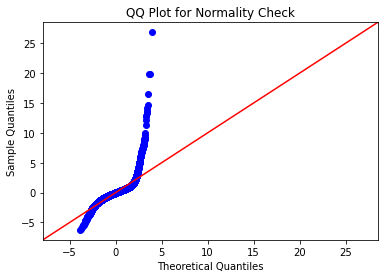

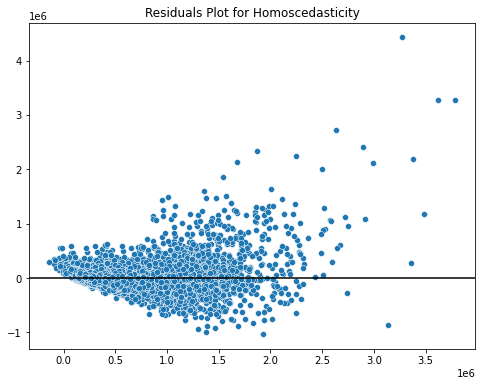

In [68]:
# Run model on first set of columns, outliers still included
# not including floors since I was on the fence on whether it should
# be categorical
x_cols = df_z.drop(['price','floors'], axis=1).columns
model1 = iterate_model_sm('price', x_cols, df_z)

#### Interpretation:
- R-squared is pretty good; about .798.
- However, residuals are neither normal, nor homoscedastic, so we can't rely on the results. The outliers being left in definitely play a big role here.
- Interesting that bathrooms has quite a high p-value.
- Some of the zip codes don't have significant p-values, but most are significant, so will leave zip codes in.
- None of the categorical conditions have significant p-values.

Before removing variables with unsignificant p-values, I'm going to remove outliers first and see how we do.

## Second Model - No Outliers

### Remove Outliers

I know that Price is very highly right-skewed with many outliers in the upper range. 

Let's try removing outliers for price, and see if that makes my model perform better.

In [69]:
def drop_outliers(df, outlier_col, method='iqr'):
    
    # isolate the column as a series
    col = df[outlier_col]
    
    if method == 'iqr':
        # determine outlier cutoff points based on iqr
        q1 = np.percentile(col, 25)
        q3 = np.percentile(col, 75)
        iqr = q3 - q1
        under = q1 - (iqr * 1.5)
        over = q3 + (iqr * 1.5)
        
        # determine how many rows, if any, will be dropped for each cutoff
        under_drop = len(df.loc[df[outlier_col] < under, outlier_col])
        over_drop = len(df.loc[df[outlier_col] > over, outlier_col])
        
        if under_drop > 0 or over_drop > 0:
            
            # create a copy of the df to work with to make sure we don't modify the
            # one passed in, if the same name is used
            df_temp = df.copy()
            
            print(f"Number of lower outliers to drop: {under_drop}")
            print(f"Number of upper outliers to drop: {over_drop}")

            if under_drop > 0:
                df_temp.drop(index=df_temp[df_temp[outlier_col] < under].index, 
                             inplace=True)

            if over_drop > 0:
                df_temp.drop(index=df_temp[df_temp[outlier_col] > over].index, 
                             inplace=True)

            return df_temp

        else:
            print("No outliers identified to be dropped.")
        
        
    else:
        print("Error: Only iqr method is supported at this time.")
    

In [70]:
# drop price outliers using IQR
df_pruned = drop_outliers(df, 'price')

Number of lower outliers to drop: 0
Number of upper outliers to drop: 1139


---------------------------------------------------------------------------
Summary of Data for column: price
---------------------------------------------------------------------------
count    2.008900e+04
mean     4.776945e+05
std      2.075929e+05
min      7.800000e+04
25%      3.150000e+05
50%      4.382000e+05
75%      6.010000e+05
max      1.120000e+06
Name: price, dtype: float64


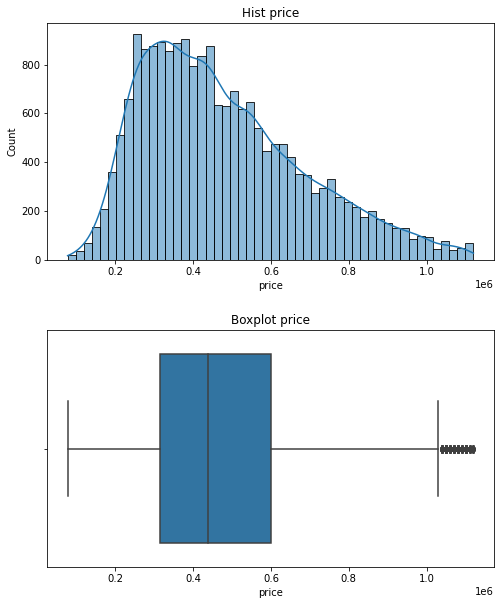


Data is NOT normal with p-value = 0.0



,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,price,1.0,continuous,1507.799341,0.0,False,NaN,477694.524765,438200.0


In [71]:
# check out price distribution with outliers removed
explore_data('price', df_pruned, 'price', plot_v_target=False)

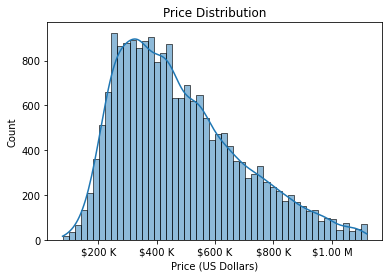

In [72]:
# Create a nicely labeled histogram

fig, ax = plt.subplots()
sns.histplot(df_pruned['price'], ax=ax, kde=True)

ax.set_title('Price Distribution')
ax.set_xlabel('Price (US Dollars)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))

Well that technically isn't normal still, but it's MUCH closer than it was before. Mean and Median are not too far off.

Let's see if the distributions and relationships for the other variables changed now that we removed the price outliers. Did this also remove other outliers?

---------------------------------------------------------------------------
Summary of Data for column: bedrooms
---------------------------------------------------------------------------
3     9435
4     6224
2     2689
5     1295
6      213
1      189
7       28
8        9
9        4
10       2
11       1
Name: bedrooms, dtype: int64


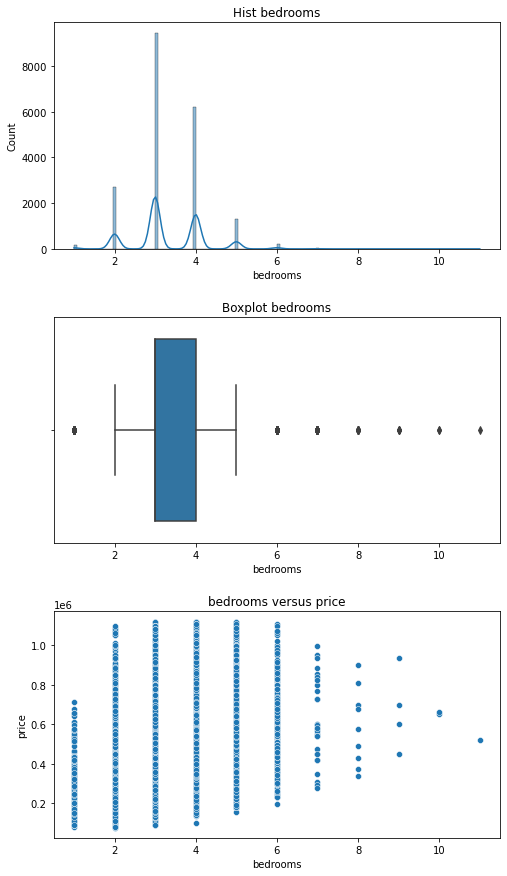


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: bathrooms
---------------------------------------------------------------------------
count    20089.000000
mean         2.053014
std          0.709471
min          0.500000
25%          1.500000
50%          2.000000
75%          2.500000
max          7.500000
Name: bathrooms, dtype: float64


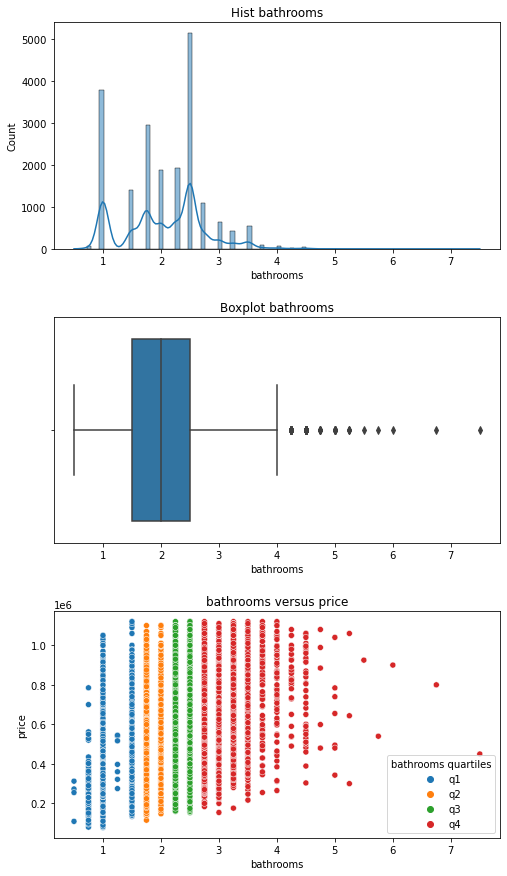


Data is NOT normal with p-value = 6.614787166252847e-42

---------------------------------------------------------------------------
Summary of Data for column: sqft_living
---------------------------------------------------------------------------
count    20089.000000
mean      1976.267111
std        774.247772
min        370.000000
25%       1400.000000
50%       1860.000000
75%       2440.000000
max       7480.000000
Name: sqft_living, dtype: float64


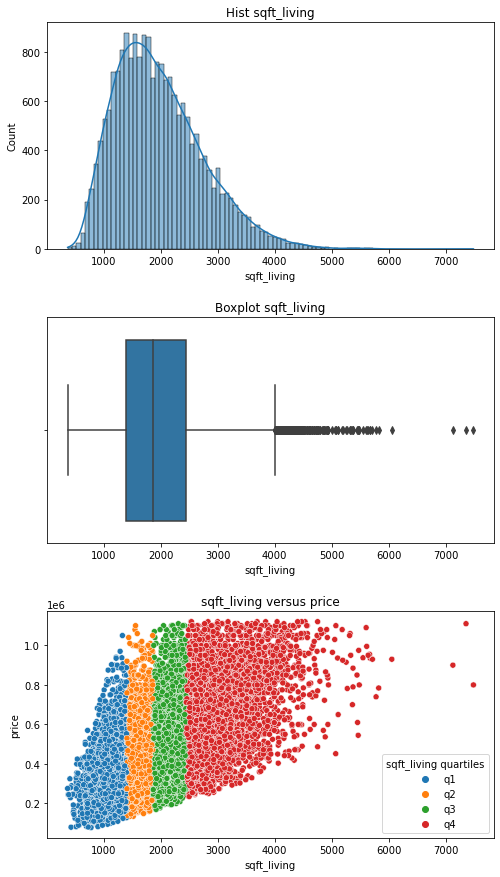


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: floors
---------------------------------------------------------------------------
1    11995
2     7525
3      569
Name: floors, dtype: int64


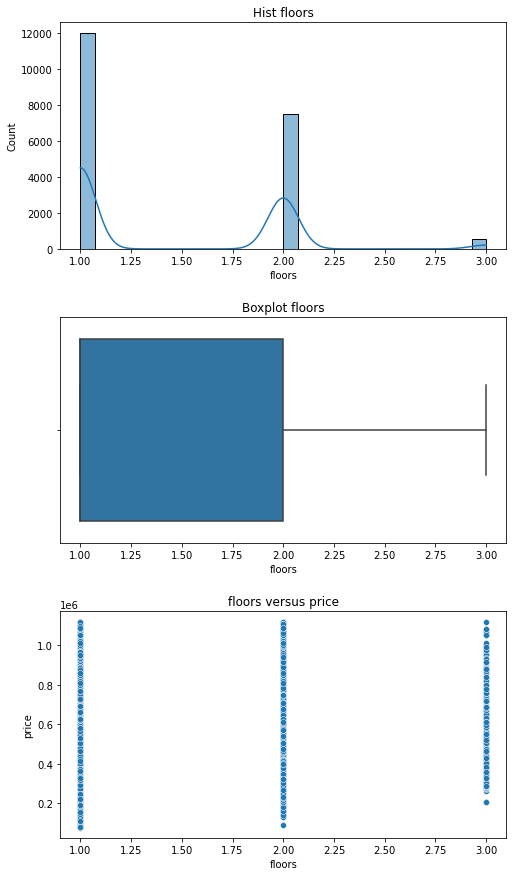


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: waterfront
---------------------------------------------------------------------------
0.0    20038
1.0       51
Name: waterfront, dtype: int64


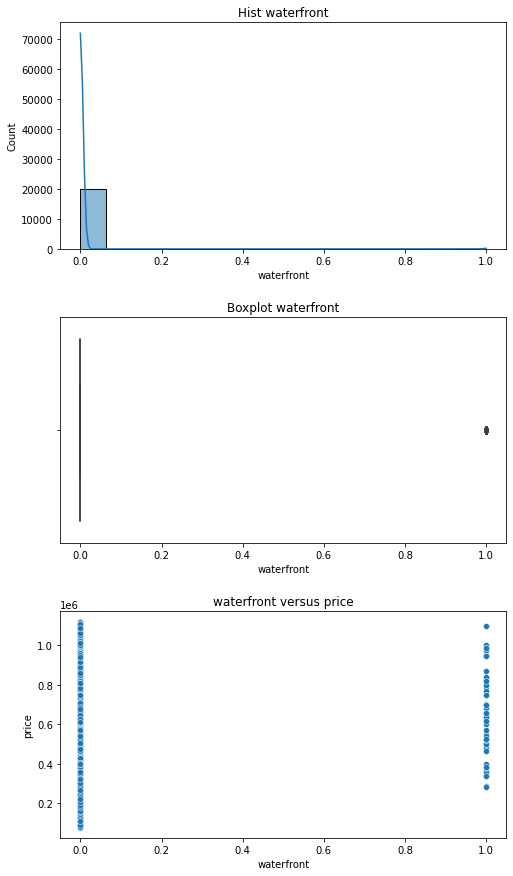


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: view
---------------------------------------------------------------------------
0    18547
1     1542
Name: view, dtype: int64


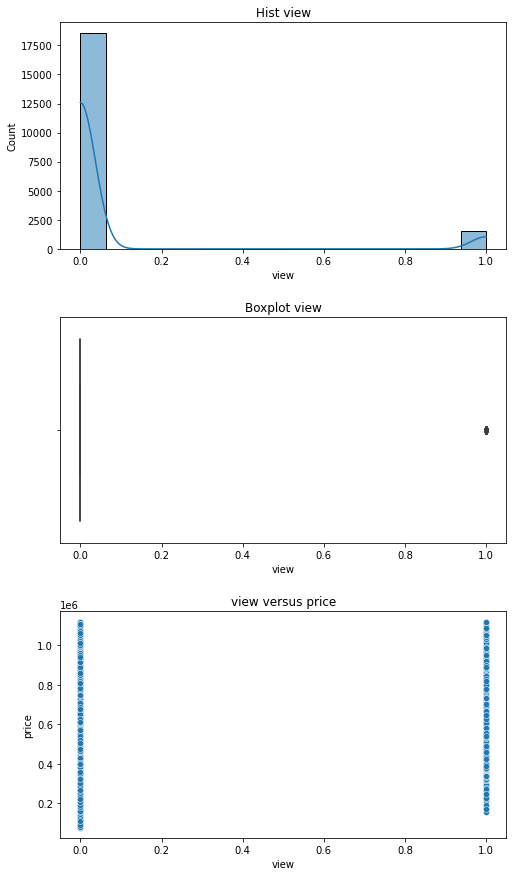


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: condition
---------------------------------------------------------------------------
3    13053
4     5325
5     1527
2      157
1       27
Name: condition, dtype: int64


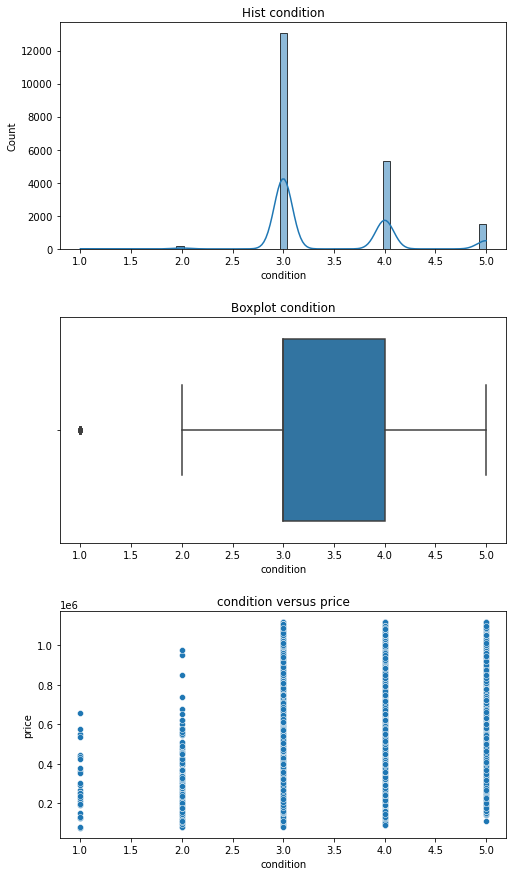


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: grade
---------------------------------------------------------------------------
7     8796
8     5856
9     2293
6     1982
10     760
5      234
11     135
4       27
12       5
3        1
Name: grade, dtype: int64


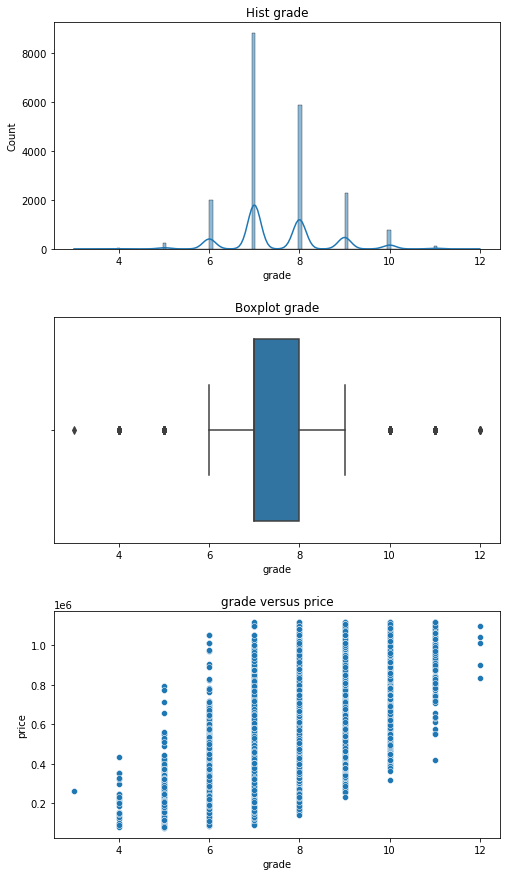


Data is NOT normal with p-value = 1.8773084842557393e-228

---------------------------------------------------------------------------
Summary of Data for column: zipcode
---------------------------------------------------------------------------
count    20089.000000
mean     98078.387426
std         53.318431
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64


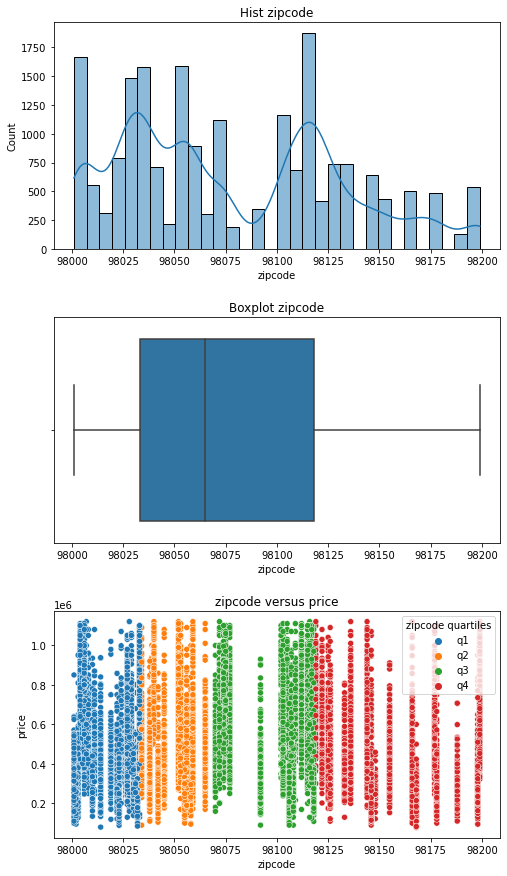


Data is NOT normal with p-value = 0.0

---------------------------------------------------------------------------
Summary of Data for column: condition_new
---------------------------------------------------------------------------
Average          13053
Above Average     6852
Below Average      184
Name: condition_new, dtype: int64
---------------------------------------------------------------------------
Summary of Data for column: has_basement
---------------------------------------------------------------------------
0    12557
1     7532
Name: has_basement, dtype: int64


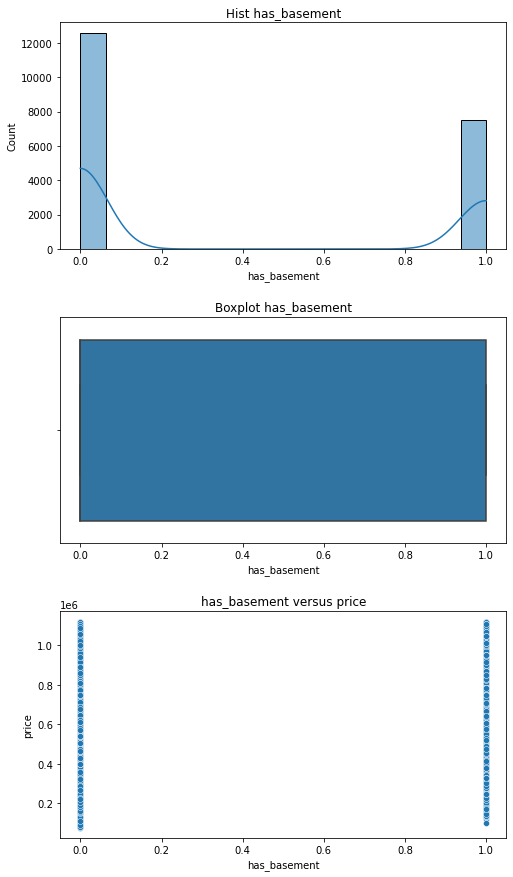


Data is NOT normal with p-value = 0.0



,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,bedrooms,0.302124,categorical,1581.226082,0.000000e+00,False,11.0,NaN,NaN
1,bathrooms,0.453597,continuous,189.638533,6.614787e-42,False,NaN,2.053014,2.0
2,sqft_living,0.621385,continuous,2183.988141,0.000000e+00,False,NaN,1976.267111,1860.0
3,floors,0.245671,categorical,1941.254448,0.000000e+00,False,3.0,NaN,NaN
4,waterfront,0.049182,categorical,43365.479250,0.000000e+00,False,2.0,NaN,NaN
5,view,0.234109,categorical,12653.979473,0.000000e+00,False,2.0,NaN,NaN
6,condition,0.034669,categorical,2660.995519,0.000000e+00,False,5.0,NaN,NaN
7,grade,0.630051,categorical,1048.719124,1.877308e-228,False,10.0,NaN,NaN
8,zipcode,-0.016286,continuous,2769.595986,0.000000e+00,False,NaN,98078.387426,98065.0
9,has_basement,0.163871,categorical,84601.122477,0.000000e+00,False,2.0,NaN,NaN


In [73]:
# Explore independent variables with price outliers removed
explore_cols = df_pruned.drop('price', axis=1).columns

explore_data(explore_cols, df_pruned, 'price')

Very interesting, so the two variables that had the highest correlation with price before removing outliers, sqft_living and grade, are still the highest, but correlation coefficients have gone down. 

It would seem that the outliers were causing the correlation coefficients to be inflated for certain variables.

The following notable variables had their coefficient reduced after removing outliers:
- sqft_living (from 0.70 to 0.62)
- grade (from 0.67 to 0.62)
- bathrooms (from 0.52 to 0.45)

### Review Multicollinearity After Outlier Removal

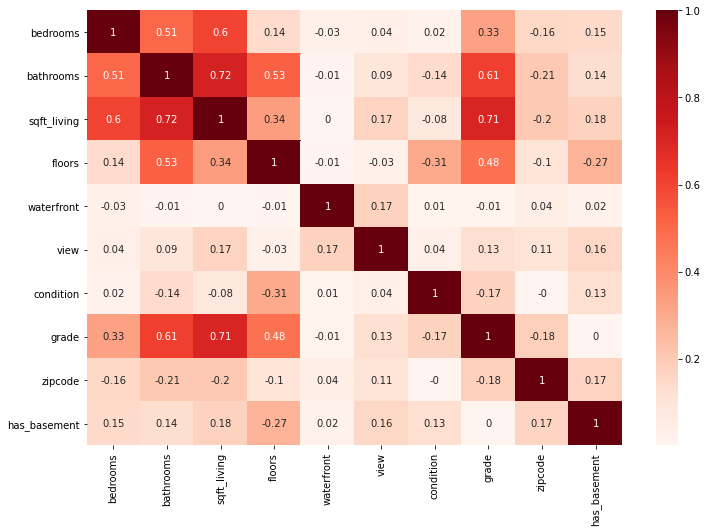

In [74]:
# Correlation matrix for IVs after outlier removal
corr_2 = df_pruned.drop('price', axis=1).corr()

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(np.abs(corr_2), cmap='Reds', 
            annot=corr_2.apply(lambda x: np.round(x, 2)));

Interestingly, the correlation between grade and sqft_living has gone down somewhat after outlier removal, from 0.76 to 0.71. This is pretty much on the cusp of a relationship we should consider a issue for multicollinearity.

### Preprocessing

In [75]:
# Create dummy columns for zip code and condition using OneHotEncoder
# the other categorical variables are already binary
# drops first category

cols = ['zipcode', 'condition']
ohe.fit(df_pruned[cols])
cats_p = pd.DataFrame(ohe.transform(df_pruned[cols]), 
                    columns=ohe.get_feature_names(cols))

# Standardize all the independent variable data to z-scores
df_p = df_pruned.drop('price', axis=1)
df_pz = (df_p - np.mean(df_p)) / np.std(df_p, ddof=0)

# concatenate standardized IVs with price in dollars
df_pz = pd.concat([df_pruned['price'], df_pz], axis=1)

# reset index to ensure rows will line up properly
df_pz.reset_index(drop=True, inplace=True)

# standardize categorical variables
cats_pz = (cats_p - np.mean(cats_p)) / np.std(cats_p, ddof=0)

# concatenate standardized variables with standardized categoricals
df_pz = pd.concat([df_pz.drop(['zipcode', 'condition', 'condition_new']
                           , axis=1), cats_pz], axis=1)
df_pz.describe()

,price,bathrooms,bedrooms,floors,grade,has_basement,sqft_living,view,waterfront,zipcode_98002,...,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,condition_2,condition_3,condition_4,condition_5
count,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,...,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04
mean,4.776945e+05,5.659159e-17,1.825079e-16,2.037297e-16,7.922822e-17,-1.301606e-16,1.414790e-16,-1.980706e-17,-3.254016e-17,-4.385848e-17,...,2.829579e-18,-4.385848e-17,-2.122184e-17,4.032151e-17,-9.903528e-18,-1.290996e-17,2.405142e-17,-1.471381e-16,-7.356906e-17,-3.395495e-17
std,2.075929e+05,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,7.800000e+04,-2.189028e+00,-2.643155e+00,-7.848108e-01,-4.376214e+00,-7.744836e-01,-2.074668e+00,-2.883403e-01,-5.044962e-02,-9.951622e-02,...,-1.149535e-01,-1.073812e-01,-1.133874e-01,-8.163738e-02,-1.167189e-01,-1.164996e-01,-8.875123e-02,-1.362048e+00,-6.005619e-01,-2.868185e-01
25%,3.150000e+05,-7.794927e-01,-3.723940e-01,-7.848108e-01,-5.164536e-01,-7.744836e-01,-7.443114e-01,-2.883403e-01,-5.044962e-02,-9.951622e-02,...,-1.149535e-01,-1.073812e-01,-1.133874e-01,-8.163738e-02,-1.167189e-01,-1.164996e-01,-8.875123e-02,-1.362048e+00,-6.005619e-01,-2.868185e-01
50%,4.382000e+05,-7.472521e-02,-3.723940e-01,-7.848108e-01,-5.164536e-01,-7.744836e-01,-1.501716e-01,-2.883403e-01,-5.044962e-02,-9.951622e-02,...,-1.149535e-01,-1.073812e-01,-1.133874e-01,-8.163738e-02,-1.167189e-01,-1.164996e-01,-8.875123e-02,7.341888e-01,-6.005619e-01,-2.868185e-01
75%,6.010000e+05,6.300423e-01,7.629866e-01,1.035120e+00,4.484866e-01,1.291183e+00,5.989613e-01,-2.883403e-01,-5.044962e-02,-9.951622e-02,...,-1.149535e-01,-1.073812e-01,-1.133874e-01,-8.163738e-02,-1.167189e-01,-1.164996e-01,-8.875123e-02,7.341888e-01,1.665107e+00,-2.868185e-01
max,1.120000e+06,7.677717e+00,8.710651e+00,2.855052e+00,4.308247e+00,1.291183e+00,7.108667e+00,3.468124e+00,1.982175e+01,1.004861e+01,...,8.699171e+00,9.312620e+00,8.819319e+00,1.224929e+01,8.567596e+00,8.583723e+00,1.126745e+01,7.341888e-01,1.665107e+00,3.486526e+00


### Model 2

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     1128.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:04:48   Log-Likelihood:            -2.5732e+05
No. Observations:               20089   AIC:                         5.148e+05
Df Residuals:                   20008   BIC:                         5.154e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.777e+05    625.159    764.117

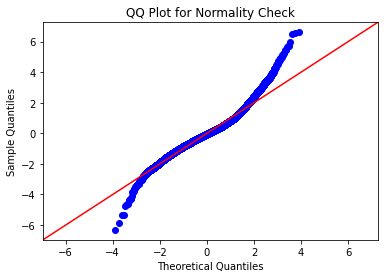

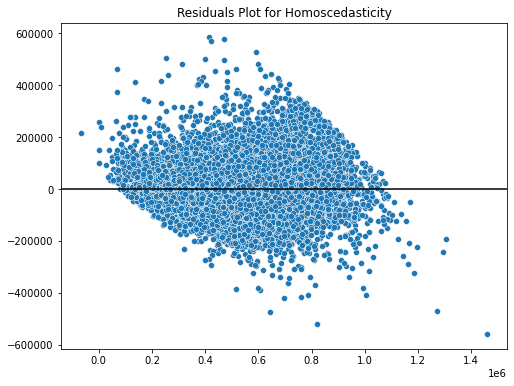

In [76]:
x_cols = df_pz.drop(['price','floors'], axis=1).columns

model2 = iterate_model_sm('price', x_cols, df_pz)

In [77]:
# determine how many of the zip codes have significant p-values
p_vals = model2.pvalues

print(f"Number of zips with significant p-values: {len(p_vals[10:].loc[p_vals < 0.05])}")
print(f"Number of zips with INsignificant p-values: {len(p_vals[10:].loc[p_vals >= 0.05])}")

Number of zips with significant p-values: 66
Number of zips with INsignificant p-values: 5


#### Interpretation:
- R-squared went up from initial model, which is good.
- Best of all, my residuals look much more normal than they were, and pretty homoscedastic. I think I can safely say my model meets assumptions for linear regression now.
- Bathrooms and my condition categories are now significant, whereas they weren't before.

## Third Model - Adjusting Dropped Categorical Variables

I was interested whether changing the categorical variables that are dropped would affect the model. The first ones are somewhat arbitrary and don't necessarily represent a reasonable baseline.

### Choose better baseline zip code

In [78]:
# what is the mean and median of housing prices across zip codes?
print(df_pruned['price'].mean())
print(df_pruned['price'].median())

477694.52476479666
438200.0


In [79]:
#Check out mean house prices per zip code. Is the fist one near the population mean?
zip_meanprices = df_pruned.groupby(['zipcode'])['price'].mean()

zip_meanprices[zip_meanprices > 450000].sort_values().head(10)


zipcode
98125    451227.861538
98028    454025.818182
98059    466748.091518
98034    474919.823077
98070    476378.912281
98024    489787.083333
98011    491935.419689
98144    507957.968051
98065    516702.698997
98136    525290.162698
Name: price, dtype: float64

Both 98034 and 98070 have mean prices pretty close to the population mean. Do they have decent sample sizes?

In [80]:
df_pruned.loc[(df_pruned['zipcode'] == 98034) | (df_pruned['zipcode'] == 98070
                                                ), 'zipcode'].value_counts()

98034    520
98070    114
Name: zipcode, dtype: int64

Will go with 98034 as the reference zip code since its mean is close to the population mean and has a larger sample size.

### Choose baseline condition
Haven't had great results from using the raw condition score as a category, but I remember not many of the houses in my population had scores of 1 or 2.

Going to pivot to using the condition_new column I engineered that represents above or below average.

Will drop Average so I can easily compare below versus above average; Average seems like a good value to use as the baseline.

In [81]:
print(df_pruned['condition_new'].value_counts())

Average          13053
Above Average     6852
Below Average      184
Name: condition_new, dtype: int64


### Preprocessing

In [82]:
# Create dummy columns for zip code and condition using OneHotEncoder
# the other categorical variables are already binary
# drops first category

# create a new ohe because will not be dropping first
ohe2 = OneHotEncoder(sparse=False)
cols = ['zipcode', 'condition_new']
ohe2.fit(df_pruned[cols])

# perform initial transform
cats_p = pd.DataFrame(ohe2.transform(df_pruned[cols]), 
                    columns=ohe2.get_feature_names(cols))

# replace spaces in column headers to avoid issues with formula in statsmodels
# also shorten 'condition' to make it display better
new_cols = [col.replace(' ', '_') for col in cats_p.columns]
new_cols = [col.replace('condition_new', 'cond') for col in new_cols]
dict_cols = dict(zip(cats_p.columns, new_cols))

cats_p.rename(columns=dict_cols, inplace=True)

# drop the appropriate columns
cats_p.drop(['cond_Average','zipcode_98034'], axis=1, inplace=True)

# Standardize all the independent variable data to z-scores
df_p = df_pruned.drop('price', axis=1)
df_pz = (df_p - np.mean(df_p)) / np.std(df_p, ddof=0)

# concatenate standardized IVs with price in dollars
df_pz = pd.concat([df_pruned['price'], df_pz], axis=1)

# reset index to ensure rows will line up properly
df_pz.reset_index(drop=True, inplace=True)

# standardize categorical variables
cats_pz = (cats_p - np.mean(cats_p)) / np.std(cats_p, ddof=0)

# concatenate standardized variables with standardized categoricals
df_pz = pd.concat([df_pz.drop(['zipcode', 'condition', 'condition_new']
                           , axis=1), cats_pz], axis=1)
df_pz.describe()

,price,bathrooms,bedrooms,floors,grade,has_basement,sqft_living,view,waterfront,zipcode_98001,...,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,cond_Above_Average,cond_Below_Average
count,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,...,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04
mean,4.776945e+05,5.659159e-17,1.825079e-16,2.037297e-16,7.922822e-17,-1.301606e-16,1.414790e-16,-1.980706e-17,-3.254016e-17,-2.122184e-18,...,-5.093243e-17,-4.385848e-17,2.829579e-18,-4.385848e-17,-2.122184e-17,4.032151e-17,-9.903528e-18,-1.290996e-17,1.018649e-16,2.405142e-17
std,2.075929e+05,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,7.800000e+04,-2.189028e+00,-2.643155e+00,-7.848108e-01,-4.376214e+00,-7.744836e-01,-2.074668e+00,-2.883403e-01,-5.044962e-02,-1.346998e-01,...,-1.480706e-01,-1.101920e-01,-1.149535e-01,-1.073812e-01,-1.133874e-01,-8.163738e-02,-1.167189e-01,-1.164996e-01,-7.194720e-01,-9.614525e-02
25%,3.150000e+05,-7.794927e-01,-3.723940e-01,-7.848108e-01,-5.164536e-01,-7.744836e-01,-7.443114e-01,-2.883403e-01,-5.044962e-02,-1.346998e-01,...,-1.480706e-01,-1.101920e-01,-1.149535e-01,-1.073812e-01,-1.133874e-01,-8.163738e-02,-1.167189e-01,-1.164996e-01,-7.194720e-01,-9.614525e-02
50%,4.382000e+05,-7.472521e-02,-3.723940e-01,-7.848108e-01,-5.164536e-01,-7.744836e-01,-1.501716e-01,-2.883403e-01,-5.044962e-02,-1.346998e-01,...,-1.480706e-01,-1.101920e-01,-1.149535e-01,-1.073812e-01,-1.133874e-01,-8.163738e-02,-1.167189e-01,-1.164996e-01,-7.194720e-01,-9.614525e-02
75%,6.010000e+05,6.300423e-01,7.629866e-01,1.035120e+00,4.484866e-01,1.291183e+00,5.989613e-01,-2.883403e-01,-5.044962e-02,-1.346998e-01,...,-1.480706e-01,-1.101920e-01,-1.149535e-01,-1.073812e-01,-1.133874e-01,-8.163738e-02,-1.167189e-01,-1.164996e-01,1.389908e+00,-9.614525e-02
max,1.120000e+06,7.677717e+00,8.710651e+00,2.855052e+00,4.308247e+00,1.291183e+00,7.108667e+00,3.468124e+00,1.982175e+01,7.423916e+00,...,6.753533e+00,9.075067e+00,8.699171e+00,9.312620e+00,8.819319e+00,1.224929e+01,8.567596e+00,8.583723e+00,1.389908e+00,1.040093e+01


In [83]:
df_pz.columns

Index(['price', 'bathrooms', 'bedrooms', 'floors', 'grade', 'has_basement',
       'sqft_living', 'view', 'waterfront', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
       'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075',
       'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103',
       'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108',
       'zipcode_98109

### Model 3

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1144.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:04:51   Log-Likelihood:            -2.5742e+05
No. Observations:               20089   AIC:                         5.150e+05
Df Residuals:                   20010   BIC:                         5.156e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           4.777e+05    628

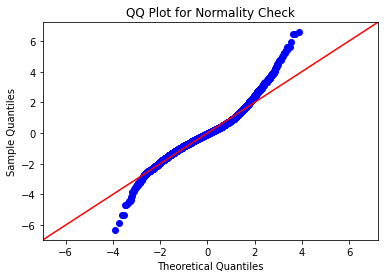

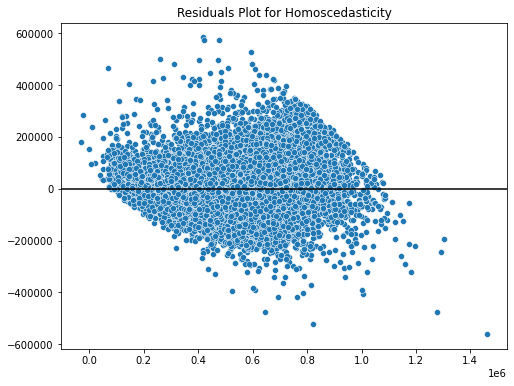

In [84]:
# re-run model with categories representing population averages dropped to
# act as the baseline

x_cols = df_pz.drop(['price','floors'], axis=1).columns

model3 = iterate_model_sm('price', x_cols, df_pz)

#### Interpretation
- R-squared went down a bit, from .818 to .816, but it isn't much of a difference. I'm going to keep it with the average categories dropped because I think it will make my model more easy to interpret.

## Fourth Model - Add more categories

Grade has one of the highest coefficients, so I'd like to be able to more granularly explain the effect of going from one grade to another.

Going to categorize grade, and also categorize floors, which I've left out so far, and see where that gets me.

I'll use the same strategy I used for condition and remove the average grade rating, (the rating that represents average), which is 7.

### Choose baseline floor category

In [85]:
# what is the mean and median of housing prices across zip codes?
print(df_pruned['floors'].mean())
print(df_pruned['floors'].median())

1.431231021952312
1.0


I'm going to use a baseline of 1 floor, which seems to be a decent average and also will make it easy to interpret my model in terms of adding a floor.

### Preprocessing

In [86]:
# Create dummy columns for zip code and condition using OneHotEncoder
# the other categorical variables are already binary
# drops first category

# create a new ohe because will not be dropping first
ohe2 = OneHotEncoder(sparse=False)
cols = ['zipcode', 'condition_new', 'grade', 'floors']
ohe2.fit(df_pruned[cols])

# perform initial transform
cats_p = pd.DataFrame(ohe2.transform(df_pruned[cols]), 
                    columns=ohe2.get_feature_names(cols))

# replace spaces in column headers to avoid issues with formula in statsmodels
# also shorten 'condition' to make it display better
new_cols = [col.replace(' ', '_') for col in cats_p.columns]
new_cols = [col.replace('condition_new', 'cond') for col in new_cols]
dict_cols = dict(zip(cats_p.columns, new_cols))

cats_p.rename(columns=dict_cols, inplace=True)
cats_p.columns

Index(['zipcode_98001', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
       'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008',
       'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019',
       'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038',
       'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045',
       'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077',
       'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 'zipcode_98105',
       'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109',
       'zipcode_98112', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117',
       'zipcode_98118', '

In [87]:
# drop the appropriate columns
cats_p.drop(['cond_Average','zipcode_98034','grade_7','floors_1'], axis=1, inplace=True)

# Standardize all the independent variable data to z-scores
df_p = df_pruned.drop('price', axis=1)
df_pz = (df_p - np.mean(df_p)) / np.std(df_p, ddof=0)

# concatenate standardized IVs with price in dollars
df_pz = pd.concat([df_pruned['price'], df_pz], axis=1)

# reset index to ensure rows will line up properly
df_pz.reset_index(drop=True, inplace=True)

# standardize categorical variables
cats_pz = (cats_p - np.mean(cats_p)) / np.std(cats_p, ddof=0)

# concatenate standardized variables with standardized categoricals
df_pz = pd.concat([df_pz.drop(['zipcode', 'condition', 'condition_new','grade',
                              'floors'], axis=1), cats_pz], axis=1)
df_pz.describe()

,price,bathrooms,bedrooms,has_basement,sqft_living,view,waterfront,zipcode_98001,zipcode_98002,zipcode_98003,...,grade_4,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,floors_2,floors_3
count,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,...,2.008900e+04,20089.000000,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04,2.008900e+04
mean,4.776945e+05,5.659159e-17,1.825079e-16,-1.301606e-16,1.414790e-16,-1.980706e-17,-3.254016e-17,-2.122184e-18,-4.385848e-17,-3.961411e-17,...,-1.344050e-17,0.000000,-5.659159e-17,3.961411e-17,-2.829579e-17,-3.112537e-17,-5.977486e-17,-3.360125e-18,-4.527327e-17,-4.527327e-17
std,2.075929e+05,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,...,1.000025e+00,1.000025,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,7.800000e+04,-2.189028e+00,-2.643155e+00,-7.744836e-01,-2.074668e+00,-2.883403e-01,-5.044962e-02,-1.346998e-01,-9.951622e-02,-1.175921e-01,...,-3.668553e-02,-0.108561,-3.308480e-01,-6.414345e-01,-3.589557e-01,-1.982906e-01,-8.225303e-02,-1.577829e-02,-7.739079e-01,-1.707325e-01
25%,3.150000e+05,-7.794927e-01,-3.723940e-01,-7.744836e-01,-7.443114e-01,-2.883403e-01,-5.044962e-02,-1.346998e-01,-9.951622e-02,-1.175921e-01,...,-3.668553e-02,-0.108561,-3.308480e-01,-6.414345e-01,-3.589557e-01,-1.982906e-01,-8.225303e-02,-1.577829e-02,-7.739079e-01,-1.707325e-01
50%,4.382000e+05,-7.472521e-02,-3.723940e-01,-7.744836e-01,-1.501716e-01,-2.883403e-01,-5.044962e-02,-1.346998e-01,-9.951622e-02,-1.175921e-01,...,-3.668553e-02,-0.108561,-3.308480e-01,-6.414345e-01,-3.589557e-01,-1.982906e-01,-8.225303e-02,-1.577829e-02,-7.739079e-01,-1.707325e-01
75%,6.010000e+05,6.300423e-01,7.629866e-01,1.291183e+00,5.989613e-01,-2.883403e-01,-5.044962e-02,-1.346998e-01,-9.951622e-02,-1.175921e-01,...,-3.668553e-02,-0.108561,-3.308480e-01,1.559006e+00,-3.589557e-01,-1.982906e-01,-8.225303e-02,-1.577829e-02,1.292143e+00,-1.707325e-01
max,1.120000e+06,7.677717e+00,8.710651e+00,1.291183e+00,7.108667e+00,3.468124e+00,1.982175e+01,7.423916e+00,1.004861e+01,8.503971e+00,...,2.725871e+01,9.211429,3.022536e+00,1.559006e+00,2.785859e+00,5.043104e+00,1.215761e+01,6.337823e+01,1.292143e+00,5.857115e+00


In [88]:
df_pz.columns

Index(['price', 'bathrooms', 'bedrooms', 'has_basement', 'sqft_living', 'view',
       'waterfront', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98038',
       'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045',
       'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077',
       'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 'zipcode_98105',
       'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109',
       'zipcode_98112',

### Model 4 - Final

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1066.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:04:53   Log-Likelihood:            -2.5700e+05
No. Observations:               20089   AIC:                         5.142e+05
Df Residuals:                   20000   BIC:                         5.149e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           4.777e+05    615

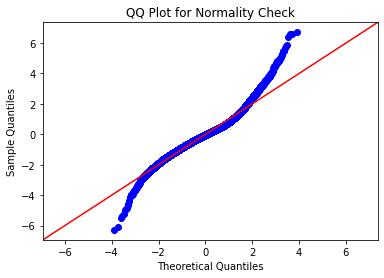

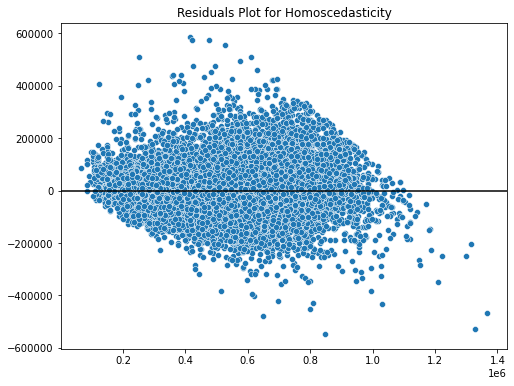

In [89]:
# re-run model with grade and floors added as categorical variables

x_cols = df_pz.drop(['price'], axis=1).columns

model4 = iterate_model_sm('price', x_cols, df_pz)

R-squared went up to 0.823, which is great! I'm going to consider this as my final model and perform some additional steps, including checking VIF and running the same model on unstandardized values to help with interpretation.

#### Interpretation
- R-squared went down a bit, from .818 to .816, but it isn't much of a difference. I'm going to keep it with the average categories dropped because I think it will make my model more easy to interpret.

In [90]:
# check VIF for multicollinearity (only for non-categorical columns)
cont_cols = ['bathrooms', 'bedrooms', 'has_basement', 'sqft_living']
eval_vif(df_pz[cont_cols], cont_cols)

,predictor,vif_score
0,bathrooms,2.089486
1,bedrooms,1.601517
2,has_basement,1.034873
3,sqft_living,2.459090


### Preprocessing for original units

In [91]:
# These should be the unstandardized versions
print(df_p.columns)
print(cats_p.columns)

print(df_p.describe())
#print(cats_p.describe())

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'zipcode', 'condition_new', 'has_basement'],
      dtype='object')
Index(['zipcode_98001', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
       'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008',
       'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019',
       'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98032', 'zipcode_98033', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',


In [ ]:
# create new df with OHE categories but in original units

# add price back in
df_p = pd.concat([df_pruned['price'], df_p], axis=1)

# reset index to ensure rows will line up properly
df_p.reset_index(drop=True, inplace=True)

# concatenate original variables with ohe categoricals
df_p = pd.concat([df_p.drop(['zipcode', 'condition', 'condition_new','grade',
                              'floors'], axis=1), cats_p], axis=1)

df_p.describe()

### Model 4 - Final in Original Units

In [ ]:
# re-run final model with values in original units

x_cols = df_p.drop(['price'], axis=1).columns

model4_orig = iterate_model_sm('price', x_cols, df_p)

In [ ]:
# check VIF for multicollinearity (only for non-categorical columns)
cont_cols = ['bathrooms', 'bedrooms', 'has_basement', 'sqft_living']
eval_vif(df_p[cont_cols], cont_cols)

Interestingly, my VIFs were under 5 when I used the standardized values, but have jumped up way above 5 when I ran on the original values.

Would removing bedrooms and bathrooms really make a difference?

### Model 5 - Test removing bedrooms and bathrooms

In [ ]:
# test removing bedrooms and bathrooms

x_cols = df_p.drop(['price','bedrooms','bathrooms'], axis=1).columns

model5 = iterate_model_sm('price', x_cols, df_p)

In [ ]:
# check VIF for multicollinearity (only for non-categorical columns)
vif_cols = df_p.drop(['price','bathrooms','bedrooms'],axis=1).columns
vifs = eval_vif(df_p, vif_cols)

In [ ]:
vifs[vifs['vif_score'] > 5]

In [ ]:
# Correlation matrix variables in my model
corr_3 = df_p[vif_cols].corr()

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(np.abs(corr_3), cmap='Reds');

Well despite a few high VIF scores, I don't see much of a correlation between any of the individual columns, just a few of the categorical ones. I'm going to stick with my original model 4 and not consider multicollinearity to be an issue.

# iNTERPRET

## Model Fit
In order to create a model that met the assumptions for a linear regression, I had to remove outliers using the IQR method, based on my target variable, Price. There were only about 1300 outliers based on price, but removing them did make the distribution for Price much more normal that it had been, and running the same model without outliers made the residuals much more normal and homoscedastic.

Since I removed outliers based on price, this means my model is only representative of homes under about \\$1.12 million.

My final model explains about 82\% of the variability in price, which is pretty good. Since I did not use a train-test split or perform cross-validation, this model is not suitable for predicting home prices, however it is suitable for describing which home features contribute most to price, which was our original goal.

## Interpreting Categories

In iterating on my model, I also chose to categorize many of the variables which were technically numeric, but had few unique variables and lent themselves naturally to categorization. 

I found categorizing these variables only minimally affected the overall R-squared value, but enabled easier interpretation of the results. 

Instead of dropping the first category, I chose to drop the categories that represented the "average" for zip codes, condition, floor, and grade.

Because of this, my baseline house (which the intercept assumes) has 0 sq ft, 0 bedrooms, 0 bathrooms, no basement, no view, and is not on the waterfront; however it is also located in a zip code where homes have mean price close to the population mean, had average grade and condition, and is a single story. These may seem incongruous, but since many of my continuous variables can't realistically equal 0, the "baseline" house was never going to be sensible.

Since baseline categories that I dropped are the average, this means we can easily compare the affect of having above average versus below average grade and condition, living in a zip code with above or below average mean price, and adding a floor from the baseline of 1.


## Individual Variable Interpretation

In [ ]:
# Get model parameter results for interpretation
df_results = pd.concat([model4.params, model4.pvalues, model4.conf_int(), 
            model4_orig.params, model4_orig.pvalues, model4_orig.conf_int()], 
                  axis=1)

df_results.columns = ['standardized_coef', 'standardized_pvalue',
                          'standardized_confmin', 'standardized_confmax',
                          'orig_units_coef', 'orig_units_pvalue',
                          'orig_units_confmin', 'orig_units_confmax']
df_results.head()

In [ ]:
# Get p-values which are not significant
display(df_results[(df_results['standardized_pvalue'] > 0.05) |
                        (df_results['orig_units_pvalue'] > 0.05)])

I kept all zip codes and grades in because the vast majority of them were significant, and I didn't want to break them apart, but a few weren't. Going to drop those from the results during analysis.

In [ ]:
# Drop predictors for small number of zip codes that weren't significant in both models
to_drop = df_results[(df_results['standardized_pvalue'] > 0.05) |
                (df_results['orig_units_pvalue'] > 0.05)].index

df_results.drop(axis=0, index=to_drop, inplace=True)

In [ ]:
# Display top 10 and bottom 10 influences on price
display(df_results.sort_values('standardized_coef', ascending=False).head(10),
        df_results.sort_values('standardized_coef', ascending=False).tail(10))

In [ ]:
# Get list of non-zipcode variables
cols = filter(lambda x : not x.startswith('zipcode') , list(df_results.index))
cols = list(cols)

# Check out just the non-zipcode variables
df_results.filter(items=cols, axis=0).sort_values('standardized_coef', 
                                                      ascending=False)

### Intercept, or baseline
Here, the intercept represents the price when all other variables are 0 and our dropped categorical variable is true. The intercept in original units is \\$223,425, so that's the price of the baseline house from which other variables add or subtract.

### Factors that detract from home price
- Not particularly surprisingly, having a condition score below average, or a grade score below average (5 or 6) will detract from our baseline home price.

- It is surprising that the addition of another bedroom, floor, or having a basement that contributes to the living sq ft (is finished) would actually reduce home price, assuming all other variables are kept constant. This does makes sense when considering that adding a bedroom, floor, or finished basement should typically go hand in hand with increasing sq footage of living space, and the coefficients we have here should be interpreted as the effect a given variable has by itself. 
    - I would not recommend adding a bedroom, for instance, by simply re-configuring the existing rooms to make some of them smaller; this will likely have the opposite effect on home value than desired!
- Living in certain zip codes can detract from home price, with 98023 being the biggest detractor.

### Factors that add to home price
- Square foot living is the most influential factor that increases home price. For every additional square foot, homeowners can expect an average increase in price of \\$115 dollars from the baseline.
- In terms of factors homeowners can control, Grade is likely to have the highest ROI compared to other options which typically require adding more square feet. The effect of having a grade of 9 or 10 is second only to having more square feet of living space.
    - Grade represents construction quality and quality of finishings. It is assigned on a scale of 1 to 13, with 7 being average.
    - Knowing that an average grade is 7, an average house with a grade of 5 or 6 will fetch a lower price than a 7. From grades 8 to 11 add progressively more value. So even improving the grade of quality and finishings to average will likely bring the average price up from the baseline.   
- The zip code in which a house is located has the next most significant impact on price compared to baseline. Being located in zip codes 98004 and 98039 gives the most boost to price.
- Having a scenic view will increase house value from the baseline by \\$77,000 on average.
- Having a house on the waterfront will increase value from the baseline by about \\$215,000 on average.
- Interestingly, adding a bathroom is the only feature that would involve a change in floorplan and would increase baseline price by itself: adding a bathroom may add to home value even without an increase in sqft. However, adding a bathroom without increasing sq ft would only increase the price by \\$10,800, so the homeowner would need to balance the cost of the renovation with the likely value the additional bathroom would bring.

In [ ]:
# rank zipcodes. Sort by original units coefficient, since original units
# are just 0 and 1 and I think the coefficient will be more representative
# of the dollar value.
cols = filter(lambda x : x.startswith('zipcode') , list(df_results.index))

with pd.option_context('display.max_rows', 100):
    display(df_results.filter(items=cols, axis=0).sort_values('orig_units_coef', 
                                                      ascending=False))


# CONCLUSIONS & RECOMMENDATIONS

## Recommendations

### 1. Sq Ft Living has the largest impact on Price
Of the variables that homeowners can somewhat reasonably control.

However, it's probably one of the more costly ways to renovate your home.

In [ ]:
sns.set_context('talk')

cols = df_results.index[1:]

non_i = df_results.filter(items=cols, axis=0).sort_values('standardized_coef', 
                                                      ascending=False).head(25)

errmin = non_i['standardized_coef'].values - non_i['standardized_confmin'].values
errmax = non_i['standardized_confmax'].values - non_i['standardized_coef'].values

fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(data=non_i, y=non_i.index, x='standardized_coef', ax=ax, orient="h")

ax.set_title('Top 25 Predictors of Increased Price')
ax.set_xlabel('Standardized Estimated Increase in Price (from Baseline)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))
ax.errorbar(x=non_i['standardized_coef'], y=non_i.index,
            xerr=[errmin,errmax], fmt='None', ecolor='black');

In [ ]:
g = sns.lmplot(data=df_pruned, x='sqft_living', y='price', 
               scatter_kws={'s':0.05}, line_kws={'color':'orange'});

ax = g.ax
ax.set_title('Sq. Ft. Living versus Price')
ax.set_ylabel('Price')
ax.set_xlabel('Total Sq. Ft. of Living Space')
ax.yaxis.set_major_formatter(plt.FuncFormatter(currency));

In [ ]:
#Create categorical variable for bedrooms
cat = pd.Categorical(df_pruned['bedrooms'].map(lambda x : str(x) if x < 5 else '5 and over'),
                     categories = ['1', '2', '3', '4', '5 and over'], ordered=True)

df_pruned['bedrooms_cat'] = cat
df_pruned['bedrooms_cat'].value_counts()

In [ ]:
# plot total square footage versus price, using bedrooms as categories
sns.set_context('talk')

g = sns.lmplot(data=df_pruned, x='sqft_living', y='price', hue='bedrooms_cat',
               scatter_kws={'s':0.001}, #line_kws={'alpha':0.75},
               legend=False);

ax = g.ax
ax.set_title('Total Sq. Ft. versus Price')
ax.set_ylabel('Price')
ax.set_xlabel('Total Sq. Ft. Living Space')
ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
ax.legend(title='Number of\n Bedrooms', loc='lower right', markerscale=300,
     fontsize='x-small', title_fontsize='x-small');

- For every sq. ft. of living space added to a home, we would expect to see an average increase in price of \\$115 from the baseline
- Adding sq. ft. to a house increases price regardless of number of bedrooms
- However, adding finished sq ft to a home may not be feasible for all homeowners, and the expected cost of renovation should be considered against any estimated price increase.


### 2. Increasing Grade level is probably the most cost effective thing to do

In [ ]:
# Check out just the grade variables
cols = filter(lambda x : x.startswith('grade') , list(df_results.index))
cols = list(cols)

cols2 = filter(lambda x : x.startswith('cond') , list(df_results.index))
cols2 = list(cols2)

[cols.append(col) for col in cols2]

grades = df_results.filter(items=cols, axis=0).sort_values('orig_units_coef', 
                                                      ascending=False)

# removing grade_12 because it was based on only 5 houses and had a very wide
# confidence interval even though it did have a significant p-value
grades.drop('grade_12', axis=0, inplace=True)

errmin = grades['orig_units_coef'].values - grades['orig_units_confmin'].values
errmax = grades['orig_units_confmax'].values - grades['orig_units_coef'].values

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(data=grades, orient='h', x='orig_units_coef', y=grades.index,
            ax=ax)
ax.set_title('Estimated Change in Baseline Price\nper Grade or Condition')
ax.set_xlabel('Estimated Change in Price (from Baseline)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))
ax.errorbar(x=grades['orig_units_coef'], y=grades.index,
            xerr=[errmin,errmax], fmt='None', ecolor='black');

- Grade represents quality of construction, workmanship, design, and finishes, where a Grade of 7 represents the average.
- A below average Grade score will detract from the baseline price, and an increase in each Grade level increases baseline price.
- Homeowners may find it simpler to renovate the finishings and craftsmanship of their home than it is to add sq. ft. Even an increase in a single grade level can make a difference.
- A home in above average Condition also increases price, but not as much as above average Grade

### 3. Considerations for Additions

In [ ]:
# Check out just the negative non-zipcode variables

# Get list of room/addition variables
cols = ['bedrooms', 'bathrooms', 'has_basement', 'floors_2', 'floors_3']

adds = df_results.filter(items=cols, axis=0).sort_values('orig_units_coef', 
                                                      ascending=False)

# drop positive coefficients
#nonzips.drop(nonzips[nonzips['orig_units_coef'] >= 0].index, axis=0, inplace=True)

errmin = adds['orig_units_coef'].values - adds['orig_units_confmin'].values
errmax = adds['orig_units_confmax'].values - adds['orig_units_coef'].values

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=adds, orient='h', x='orig_units_coef', y=adds.index,
            ax=ax)
ax.set_title('Estimated Change in Baseline Price\nfor Additions')
ax.set_xlabel('Estimated Change in Price (from Baseline)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))
ax.yaxis.set_ticklabels(['Add a Bathroom', 'Add a Bedroom', 'Add Second Floor', 
                         'Finish Basement', 'Add Third Floor'])
ax.errorbar(x=adds['orig_units_coef'], y=adds.index,
            xerr=[errmin,errmax], fmt='None', ecolor='black');

- Interestingly, adding a bathroom is the only variable we analyzed that increased price without changing anything else, such as adding more square feet.
- We can interpret this by concluding that the other types of additions also require adding square feet to increase price.
- When calculating cost versus estimated price increase for additions, homeowners should consider whether they're adding enough square feet.


In [ ]:
# Calculate how many sq ft should be added to break even on each room type
adds.drop('bathrooms', axis=0, inplace=True, errors='ignore')

# get coefficient for sq ft (amount price goes up for each sq ft)
sqft_coef = np.array(df_results.filter(['sqft_living'], axis=0)['orig_units_coef'])[0]

# All of the room variables representing adding one. Divide their coefficients
# by sq ft coefficient to get the number of sq ft to break even
break_evens = np.abs(adds['orig_units_coef']) / sqft_coef

print("Number of square feet to add to break even on each room type:")
print(np.round(break_evens,2))

Adding more square feet to any size home will increase its price.

However, square footage can be put towards adding a bedroom, or can also add to general living space, such as finishing a basement or adding an enclosed porch. 

If a homeowner were to simply reconfigure the interior to add a bedroom without adding more square feet of living space or changing anything else, our model shows that the home price would actually go down by \\$3,510 (+/- \\$1845). Considering some or all of the rooms would be smaller in this case, it makes sense that cramming in an extra bedroom isn't useful.

Since each additional square foot of living space is expected to increase price by an average of \\$115, homeowners should plan to add at least 30 sq. ft. (+/- 16 sq. ft.) when adding a bedroom. Since technically a bedroom under 30 sq. ft. would like decrease the price, when estimating expected increase in price from adding a bedroom, homeowners should subtract 30 from the square footage they intend to add.

This math assumes there is no multicollinearity between bedrooms and sq. ft., and that each coefficient represents the impact of a unit change in that variable independently of other variables. However, sq. ft. living may be multicollinear with some of these addition variables such as bedrooms, so these should be considered estimates.

## Potential Next Steps

The multiple linear regression model is fairly easy to interpret, so it was the best choice for this initial analysis to identify which variables impact price the most.

However, it may not be the most effective way to model housing data for prediction, and more steps would be needed to test accuracy of predictions. As next steps, I would recommend using the same model parameters but properly splitting for training and testing data to determine whether this model would be suitably accurate for predictions. If a reasonably accurate model can be achieved, this would enable Acme to make better recommendations for their clients based on multiple factors.

# Extra

In [ ]:
# Create a ratio of sqft living to bedrooms
# larger values means more living space for the number of bedrooms
df_pruned['sqft_per_bed'] = df_pruned.apply(
    lambda x : x['sqft_living'] / x['bedrooms'], axis=1)

In [ ]:
# Create a ratio price per sqft
df_pruned['price_per_sqft'] = df_pruned.apply(
    lambda x : x['price'] / x['sqft_living'], axis=1)

In [ ]:
# get average price per sq ft across the board
print(f"Mean price per sq ft: {df_pruned['price_per_sqft'].mean()}")
print(f"Median price per sq ft: {df_pruned['price_per_sqft'].median()}")

In [ ]:
# Get average price per sq ft for houses with different numbers of bedrooms
df_pruned.groupby(by='bedrooms_cat')['price_per_sqft'].mean()

The average price per sq. ft. is highest for one-bedroom homes, and decreases as more bedrooms are added. This makes sense given that homes with more bedrooms don't necessarily have proportionally more sq. ft. devoted to non-bedroom areas; a 3-bedroom house may still have the same size kitchen and living room as a 1- or 2-bedroom house, for example.